In [1]:
%matplotlib inline

# Gaussian process models for stellar variability

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

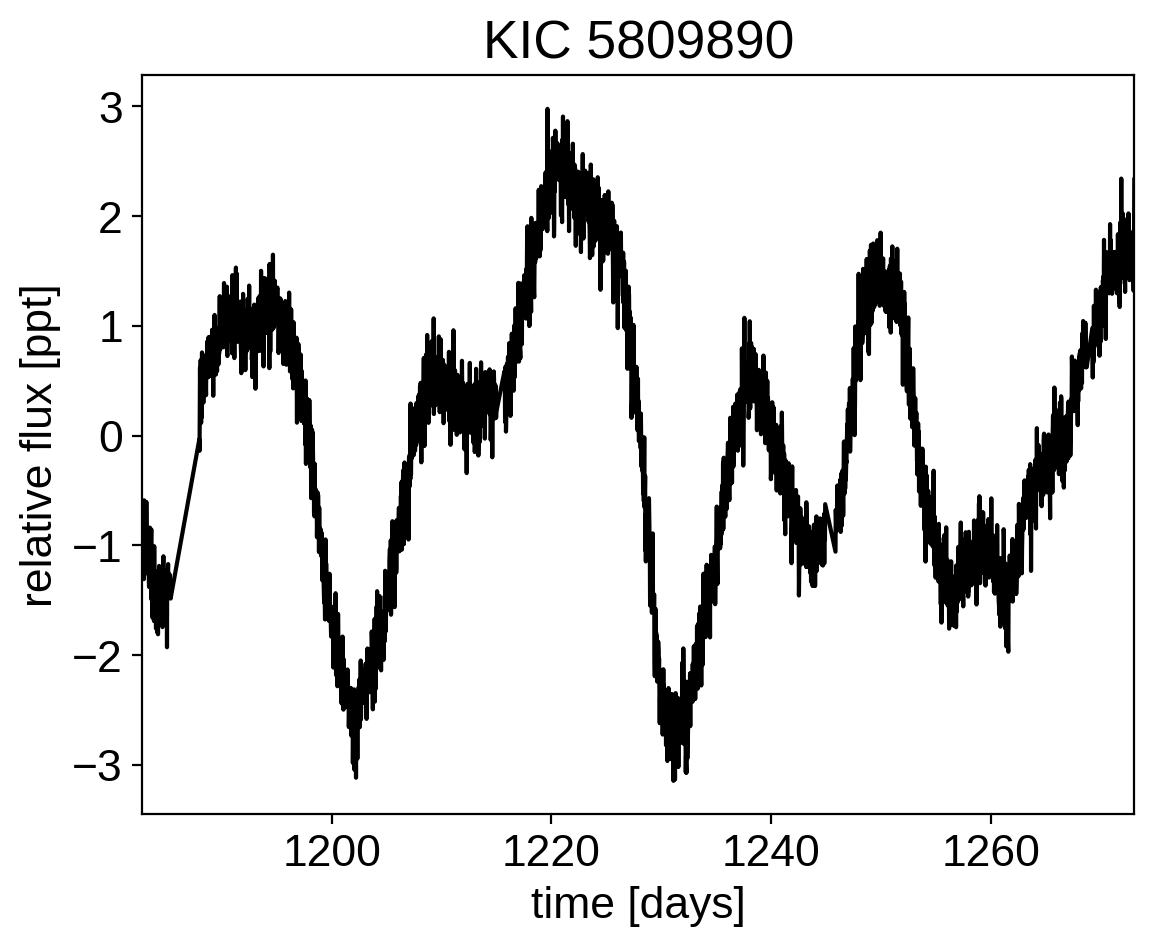

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    hdr = hdus[1].header
    
# Work out the exposure time
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0    

x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

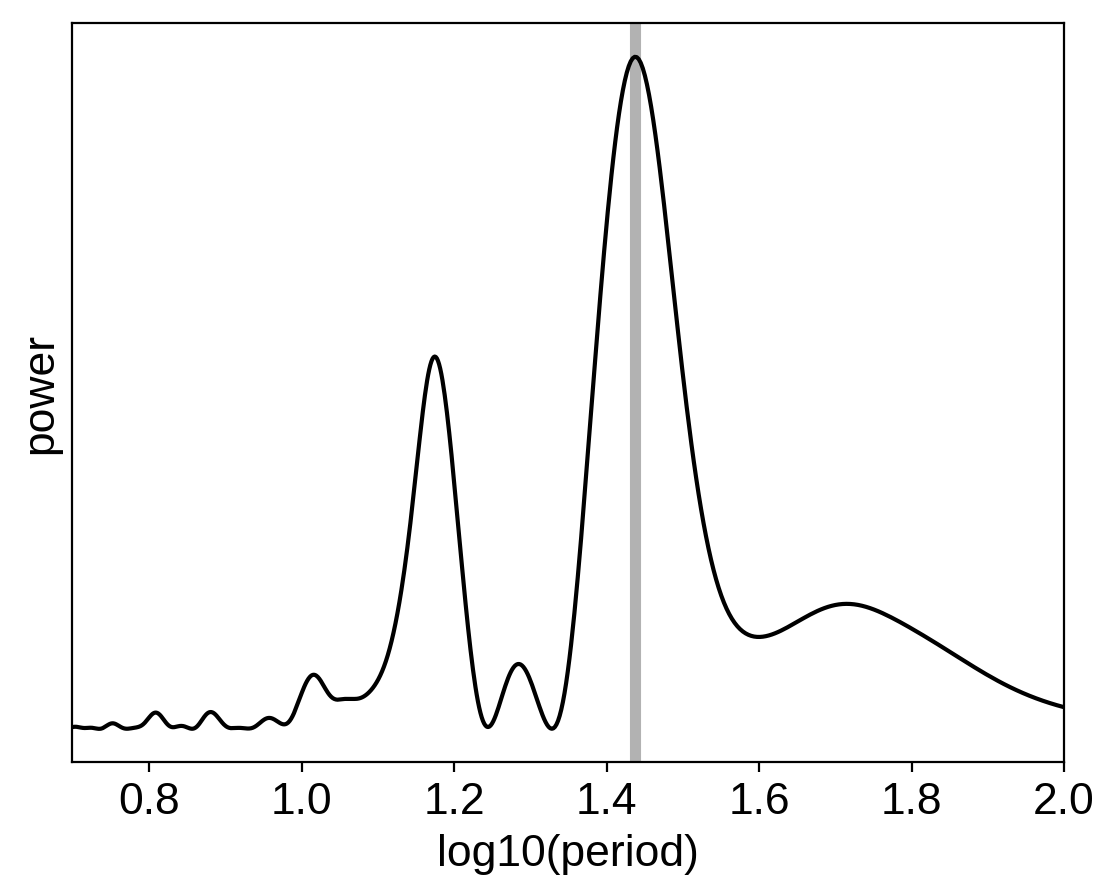

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod_interval__', 'logamp', 'logs2', 'mean']


message: Optimization terminated successfully.
logp: 263.10222197490816 -> 692.0354844282873


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

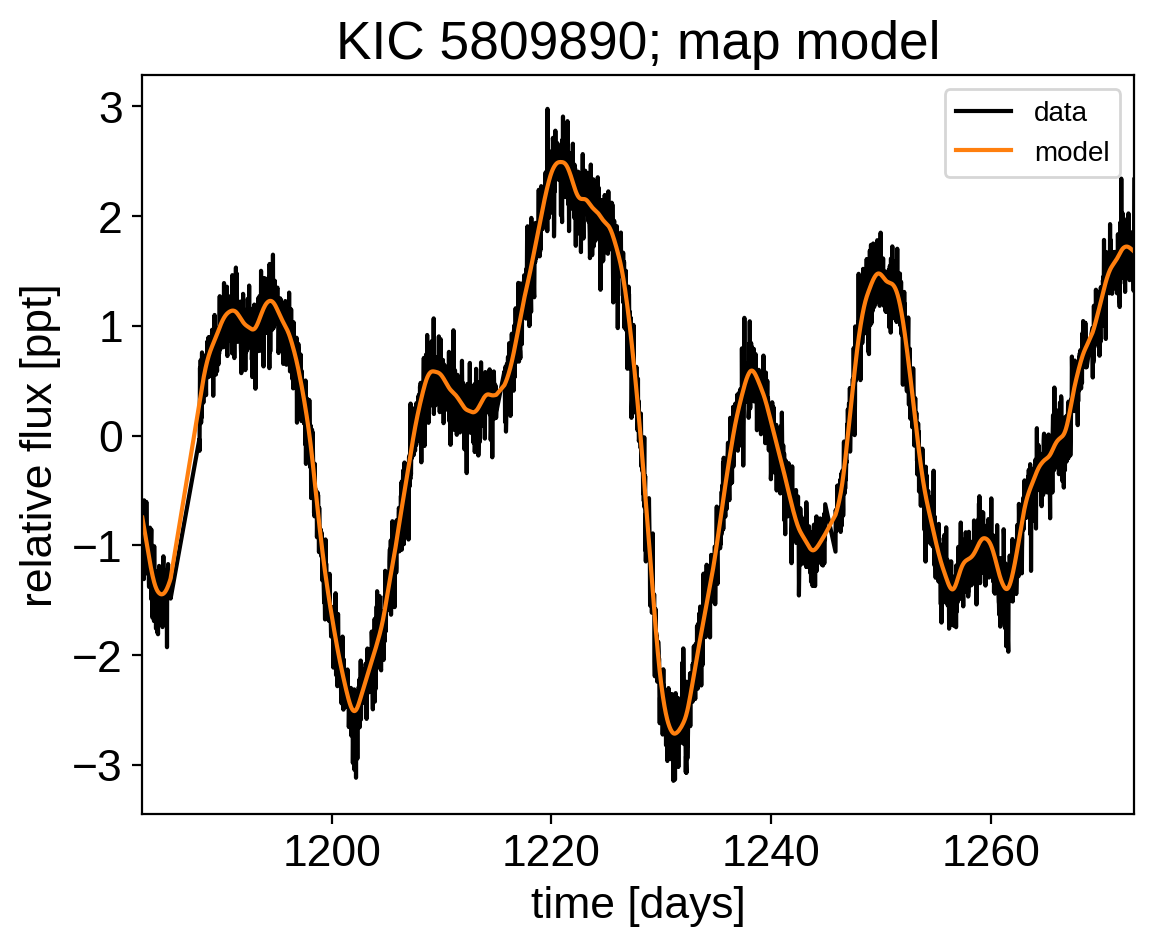

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 7/308 [00:00<00:08, 34.15draws/s]

Sampling 4 chains:   3%|▎         | 10/308 [00:00<00:17, 16.96draws/s]

Sampling 4 chains:   4%|▎         | 11/308 [00:00<00:22, 13.04draws/s]

Sampling 4 chains:   4%|▍         | 13/308 [00:00<00:22, 13.27draws/s]

Sampling 4 chains:   5%|▍         | 15/308 [00:00<00:20, 14.30draws/s]

Sampling 4 chains:   6%|▌         | 17/308 [00:01<00:26, 10.87draws/s]

Sampling 4 chains:   6%|▋         | 20/308 [00:01<00:21, 13.37draws/s]

Sampling 4 chains:   7%|▋         | 22/308 [00:01<00:21, 13.51draws/s]

Sampling 4 chains:   8%|▊         | 24/308 [00:01<00:31,  8.94draws/s]

Sampling 4 chains:   8%|▊         | 26/308 [00:02<00:31,  8.87draws/s]

Sampling 4 chains:  10%|▉         | 30/308 [00:02<00:25, 10.96draws/s]

Sampling 4 chains:  11%|█▏        | 35/308 [00:02<00:19, 13.97draws/s]

Sampling 4 chains:  12%|█▏        | 38/308 [00:02<00:16, 16.37draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:02<00:18, 14.72draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:02<00:15, 16.91draws/s]

Sampling 4 chains:  16%|█▌        | 48/308 [00:03<00:14, 17.83draws/s]

Sampling 4 chains:  17%|█▋        | 51/308 [00:03<00:12, 20.18draws/s]

Sampling 4 chains:  18%|█▊        | 54/308 [00:03<00:15, 16.86draws/s]

Sampling 4 chains:  19%|█▊        | 57/308 [00:03<00:13, 19.26draws/s]

Sampling 4 chains:  19%|█▉        | 60/308 [00:03<00:11, 21.30draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:03<00:10, 23.67draws/s]

Sampling 4 chains:  22%|██▏       | 68/308 [00:03<00:10, 23.62draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:04<00:11, 20.36draws/s]

Sampling 4 chains:  24%|██▍       | 74/308 [00:04<00:10, 21.81draws/s]

Sampling 4 chains:  25%|██▌       | 77/308 [00:04<00:09, 23.39draws/s]

Sampling 4 chains:  26%|██▌       | 80/308 [00:04<00:10, 22.39draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:04<00:10, 21.48draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:04<00:10, 20.92draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:05<00:10, 21.14draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:05<00:11, 18.81draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:05<00:12, 16.75draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:05<00:16, 12.83draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:05<00:16, 12.62draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:05<00:16, 12.44draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:06<00:12, 16.08draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:06<00:12, 16.09draws/s]

Sampling 4 chains:  37%|███▋      | 115/308 [00:06<00:09, 19.56draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:06<00:13, 14.33draws/s]

Sampling 4 chains:  40%|███▉      | 122/308 [00:06<00:12, 15.12draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:07<00:10, 17.24draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:07<00:14, 12.82draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:07<00:13, 12.92draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:07<00:12, 14.29draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:07<00:10, 16.78draws/s]

Sampling 4 chains:  45%|████▌     | 140/308 [00:08<00:09, 18.40draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:08<00:10, 16.03draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [00:08<00:09, 17.60draws/s]

Sampling 4 chains:  48%|████▊     | 148/308 [00:08<00:11, 13.96draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:08<00:10, 15.39draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [00:08<00:08, 18.72draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [00:09<00:08, 18.65draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:09<00:08, 17.71draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:09<00:07, 19.34draws/s]

Sampling 4 chains:  55%|█████▍    | 168/308 [00:09<00:09, 14.15draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:09<00:08, 15.22draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:09<00:08, 16.18draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:10<00:08, 16.42draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:10<00:06, 19.69draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:10<00:06, 19.39draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [00:10<00:05, 21.44draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:10<00:07, 15.38draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [00:10<00:06, 17.41draws/s]

Sampling 4 chains:  64%|██████▎   | 196/308 [00:11<00:05, 19.78draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [00:11<00:05, 19.46draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [00:11<00:05, 21.09draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:11<00:05, 18.20draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:11<00:05, 18.34draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:12<00:04, 19.44draws/s]

Sampling 4 chains:  70%|███████   | 216/308 [00:12<00:04, 20.91draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [00:12<00:04, 20.60draws/s]

Sampling 4 chains:  73%|███████▎  | 225/308 [00:12<00:03, 22.01draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [00:12<00:03, 22.46draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [00:12<00:03, 23.07draws/s]

Sampling 4 chains:  77%|███████▋  | 237/308 [00:13<00:03, 21.24draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [00:13<00:03, 21.99draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:13<00:02, 21.78draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [00:13<00:02, 21.21draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:13<00:02, 19.45draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:13<00:03, 15.05draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:14<00:03, 15.83draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:14<00:03, 14.59draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:14<00:03, 13.17draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [00:14<00:03, 13.62draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:14<00:03, 14.87draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [00:14<00:02, 14.85draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:14<00:02, 18.06draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:15<00:01, 20.13draws/s]

Sampling 4 chains:  89%|████████▉ | 275/308 [00:15<00:01, 20.58draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:15<00:02, 14.22draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:15<00:01, 14.21draws/s]

Sampling 4 chains:  92%|█████████▏| 283/308 [00:15<00:01, 16.70draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:16<00:01, 14.29draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:16<00:01, 13.22draws/s]

Sampling 4 chains:  94%|█████████▍| 291/308 [00:16<00:01, 14.98draws/s]

Sampling 4 chains:  95%|█████████▌| 293/308 [00:16<00:01, 12.91draws/s]

Sampling 4 chains:  96%|█████████▌| 295/308 [00:16<00:00, 13.83draws/s]

Sampling 4 chains:  96%|█████████▋| 297/308 [00:17<00:01,  6.68draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [00:17<00:01,  7.67draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [00:18<00:01,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:18<00:01,  3.02draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:18<00:01,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:19<00:01,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:19<00:00,  2.83draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:20<00:00,  2.41draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:21<00:00,  2.29draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:   9%|▉         | 10/108 [00:00<00:01, 68.13draws/s]

Sampling 4 chains:  12%|█▏        | 13/108 [00:00<00:04, 22.06draws/s]

Sampling 4 chains:  14%|█▍        | 15/108 [00:00<00:05, 16.79draws/s]

Sampling 4 chains:  17%|█▋        | 18/108 [00:00<00:05, 17.70draws/s]

Sampling 4 chains:  19%|█▊        | 20/108 [00:01<00:06, 13.71draws/s]

Sampling 4 chains:  20%|██        | 22/108 [00:01<00:07, 11.70draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:01<00:06, 13.16draws/s]

Sampling 4 chains:  26%|██▌       | 28/108 [00:01<00:05, 15.62draws/s]

Sampling 4 chains:  30%|██▉       | 32/108 [00:01<00:04, 18.70draws/s]

Sampling 4 chains:  34%|███▍      | 37/108 [00:01<00:03, 22.98draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:01<00:02, 26.26draws/s]

Sampling 4 chains:  43%|████▎     | 46/108 [00:01<00:02, 29.45draws/s]

Sampling 4 chains:  46%|████▋     | 50/108 [00:02<00:01, 30.81draws/s]

Sampling 4 chains:  50%|█████     | 54/108 [00:02<00:02, 25.74draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:02<00:01, 28.32draws/s]

Sampling 4 chains:  57%|█████▋    | 62/108 [00:02<00:01, 23.64draws/s]

Sampling 4 chains:  60%|██████    | 65/108 [00:02<00:01, 24.23draws/s]

Sampling 4 chains:  63%|██████▎   | 68/108 [00:02<00:01, 22.09draws/s]

Sampling 4 chains:  69%|██████▉   | 75/108 [00:03<00:01, 27.06draws/s]

Sampling 4 chains:  73%|███████▎  | 79/108 [00:03<00:01, 25.16draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:03<00:00, 28.52draws/s]

Sampling 4 chains:  81%|████████▏ | 88/108 [00:03<00:00, 29.68draws/s]

Sampling 4 chains:  85%|████████▌ | 92/108 [00:03<00:00, 31.40draws/s]

Sampling 4 chains:  89%|████████▉ | 96/108 [00:03<00:00, 26.35draws/s]

Sampling 4 chains:  92%|█████████▏| 99/108 [00:04<00:00, 14.84draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:04<00:00, 11.37draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:04<00:00, 13.80draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:05<00:00, 11.91draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 8/208 [00:00<00:02, 76.00draws/s]

Sampling 4 chains:   9%|▊         | 18/208 [00:00<00:02, 81.24draws/s]

Sampling 4 chains:  12%|█▎        | 26/208 [00:00<00:02, 79.72draws/s]

Sampling 4 chains:  17%|█▋        | 36/208 [00:00<00:02, 84.25draws/s]

Sampling 4 chains:  21%|██        | 43/208 [00:00<00:02, 65.10draws/s]

Sampling 4 chains:  24%|██▎       | 49/208 [00:00<00:03, 52.20draws/s]

Sampling 4 chains:  26%|██▋       | 55/208 [00:00<00:03, 48.17draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:01<00:02, 50.65draws/s]

Sampling 4 chains:  32%|███▏      | 67/208 [00:01<00:02, 51.20draws/s]

Sampling 4 chains:  37%|███▋      | 76/208 [00:01<00:02, 57.61draws/s]

Sampling 4 chains:  40%|████      | 84/208 [00:01<00:02, 60.70draws/s]

Sampling 4 chains:  44%|████▍     | 91/208 [00:01<00:02, 57.24draws/s]

Sampling 4 chains:  47%|████▋     | 98/208 [00:01<00:01, 58.42draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:01<00:01, 62.71draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:01<00:01, 63.22draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:01<00:01, 65.21draws/s]

Sampling 4 chains:  62%|██████▏   | 129/208 [00:02<00:01, 59.38draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [00:02<00:01, 60.99draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [00:02<00:01, 60.84draws/s]

Sampling 4 chains:  72%|███████▏  | 150/208 [00:02<00:00, 61.26draws/s]

Sampling 4 chains:  75%|███████▌  | 157/208 [00:02<00:00, 59.00draws/s]

Sampling 4 chains:  80%|███████▉  | 166/208 [00:02<00:00, 65.20draws/s]

Sampling 4 chains:  83%|████████▎ | 173/208 [00:02<00:00, 65.32draws/s]

Sampling 4 chains:  87%|████████▋ | 180/208 [00:02<00:00, 66.65draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [00:02<00:00, 69.27draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [00:03<00:00, 69.36draws/s]

Sampling 4 chains:  99%|█████████▊| 205/208 [00:03<00:00, 58.37draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:03<00:00, 60.05draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:05, 78.25draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:00<00:04, 81.30draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:05, 74.84draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:04, 75.50draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:00<00:04, 73.61draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:00<00:04, 72.80draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:05, 70.12draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:00<00:06, 54.73draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:01<00:06, 52.25draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:01<00:06, 52.08draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:01<00:06, 52.18draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:01<00:05, 55.85draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:01<00:06, 52.50draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:01<00:05, 53.56draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:01<00:05, 51.25draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:01<00:06, 46.23draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:05, 48.68draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:02<00:05, 51.49draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:02<00:05, 53.26draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:02<00:04, 54.58draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:02<00:04, 57.88draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:02<00:04, 60.31draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:02<00:04, 62.27draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:02<00:03, 65.18draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:02<00:03, 68.34draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:03<00:03, 66.60draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:03<00:03, 68.59draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:03<00:03, 66.75draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:03<00:03, 64.62draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:03<00:02, 70.11draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:03<00:02, 73.45draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:03<00:02, 74.04draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:03<00:02, 69.65draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:03<00:02, 69.89draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:04<00:02, 71.54draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:04<00:01, 77.50draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:04<00:01, 73.47draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:04<00:01, 73.99draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:04<00:01, 73.45draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:04<00:01, 69.28draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:04<00:01, 74.20draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:04<00:01, 71.54draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:04<00:01, 71.98draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:05<00:01, 73.87draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:05<00:00, 68.50draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:05<00:01, 58.01draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:05<00:01, 52.78draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:05<00:00, 50.69draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:05<00:00, 50.37draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:05<00:00, 51.72draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:06<00:00, 56.68draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:06<00:00, 52.97draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:06<00:00, 49.27draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:06<00:00, 40.85draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:06<00:00, 37.37draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 27.88draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<00:11, 66.95draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:00<00:11, 66.85draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:13, 57.37draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:15, 51.66draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:15, 51.05draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:14, 54.90draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:13, 54.76draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:00<00:13, 55.04draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:14, 52.88draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:01<00:15, 49.35draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:15, 49.13draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:17, 41.05draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:01<00:19, 36.84draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:01<00:17, 41.05draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:15, 46.59draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:02<00:16, 42.90draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:02<00:20, 35.14draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:02<00:18, 38.36draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:02<00:19, 36.31draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:02<00:17, 38.76draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:02<00:16, 42.47draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:02<00:14, 45.98draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:02<00:13, 50.44draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:03<00:11, 56.17draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:03<00:11, 58.38draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:03<00:12, 53.04draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:03<00:11, 54.50draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:03<00:11, 52.88draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:03<00:11, 54.20draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:03<00:11, 52.02draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:03<00:11, 53.36draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:04<00:10, 58.88draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:04<00:09, 62.45draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:04<00:09, 60.77draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:04<00:10, 55.11draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:04<00:10, 56.18draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:04<00:10, 52.48draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:04<00:11, 50.81draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:04<00:12, 44.93draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:05<00:11, 48.71draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:05<00:10, 53.55draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:05<00:09, 55.29draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:05<00:08, 61.61draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:05<00:08, 62.69draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:05<00:07, 66.58draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:05<00:07, 67.29draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:05<00:08, 60.35draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:06<00:08, 58.70draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:06<00:08, 57.95draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:06<00:08, 57.15draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:06<00:08, 55.11draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:06<00:08, 55.72draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:06<00:07, 64.22draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:06<00:06, 66.58draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:06<00:06, 68.52draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:06<00:06, 67.50draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:07<00:05, 69.68draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:07<00:05, 72.11draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:07<00:05, 73.91draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:07<00:05, 70.47draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:07<00:05, 71.22draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:07<00:05, 67.80draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:07<00:05, 73.17draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:07<00:04, 76.30draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:08<00:04, 73.93draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:08<00:04, 76.50draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:08<00:04, 81.84draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:08<00:04, 80.33draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:08<00:04, 75.21draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:08<00:04, 76.07draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:08<00:04, 74.05draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:08<00:03, 73.68draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:08<00:03, 71.77draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:09<00:04, 65.40draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:09<00:04, 66.48draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:09<00:03, 70.66draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:09<00:03, 70.20draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:09<00:03, 74.78draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:09<00:03, 66.97draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:09<00:03, 63.80draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:09<00:03, 64.66draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:10<00:02, 69.07draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:10<00:02, 72.34draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:10<00:02, 78.89draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:10<00:02, 81.83draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:10<00:02, 79.10draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:10<00:02, 76.35draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:10<00:02, 73.67draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:10<00:01, 73.41draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:10<00:01, 68.83draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:11<00:01, 67.81draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:11<00:01, 70.50draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:11<00:01, 72.94draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:11<00:01, 71.47draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:11<00:01, 73.32draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:11<00:01, 75.37draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:11<00:01, 72.16draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:11<00:00, 71.38draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:12<00:00, 61.78draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:12<00:00, 60.93draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:12<00:00, 50.34draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:12<00:00, 47.12draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:12<00:00, 47.01draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:12<00:00, 40.34draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:12<00:00, 37.30draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:13<00:00, 34.97draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:13<00:00, 28.24draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:13<00:00, 23.91draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:13<00:00, 22.92draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:13<00:00, 21.30draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:14<00:00, 15.75draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:14<00:00, 13.33draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:14<00:00, 55.96draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/1608 [00:00<00:25, 61.96draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<00:25, 61.33draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:00<00:26, 60.76draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:00<00:26, 60.02draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:00<00:25, 62.31draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:00<00:27, 57.65draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:00<00:28, 54.60draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:00<00:26, 57.87draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:01<00:29, 52.11draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:01<00:31, 48.66draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:01<00:32, 46.62draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:01<00:30, 49.27draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:01<00:29, 51.62draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:01<00:26, 56.94draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:01<00:24, 61.01draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:01<00:23, 64.06draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:02<00:23, 62.10draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:02<00:27, 54.54draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:02<00:25, 56.83draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:02<00:29, 49.75draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:02<00:28, 51.71draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:02<00:26, 55.20draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:02<00:27, 53.43draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:02<00:27, 53.39draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:03<00:27, 53.03draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:03<00:25, 56.62draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:03<00:25, 55.92draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:03<00:24, 58.57draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:03<00:23, 61.05draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:03<00:21, 63.94draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:03<00:22, 60.94draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:03<00:27, 49.75draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:04<00:24, 55.57draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:04<00:23, 58.86draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:04<00:23, 58.21draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:04<00:21, 62.65draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:04<00:22, 60.05draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:04<00:22, 58.84draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:04<00:21, 61.76draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:04<00:19, 66.40draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:04<00:19, 66.72draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:05<00:20, 63.25draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:05<00:20, 64.13draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:05<00:19, 66.60draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:05<00:19, 66.24draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:05<00:20, 62.30draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:05<00:20, 62.19draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:05<00:18, 66.87draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:05<00:16, 75.30draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:06<00:16, 73.23draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:06<00:18, 65.19draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:06<00:22, 54.76draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:06<00:19, 61.53draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:06<00:18, 65.32draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:06<00:18, 64.41draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:06<00:18, 64.97draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:06<00:17, 67.28draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:07<00:18, 63.58draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:07<00:19, 59.66draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:07<00:17, 65.80draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:07<00:18, 64.21draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:07<00:17, 65.32draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:07<00:17, 64.71draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:07<00:18, 61.35draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:07<00:17, 63.57draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:07<00:17, 64.30draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:08<00:17, 65.36draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [00:08<00:15, 69.57draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:08<00:15, 71.17draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [00:08<00:14, 73.50draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:08<00:14, 74.68draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [00:08<00:15, 70.11draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [00:08<00:15, 68.06draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:08<00:15, 68.14draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:09<00:16, 64.63draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:09<00:15, 66.09draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [00:09<00:15, 64.81draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [00:09<00:16, 62.72draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [00:09<00:16, 61.73draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:09<00:17, 56.57draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [00:09<00:17, 58.45draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [00:09<00:17, 58.26draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [00:09<00:15, 63.62draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [00:10<00:14, 67.13draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:10<00:14, 65.25draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [00:10<00:14, 68.97draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [00:10<00:13, 71.08draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [00:10<00:13, 68.81draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:10<00:13, 67.89draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:10<00:12, 75.66draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [00:10<00:12, 73.48draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [00:10<00:12, 71.17draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [00:11<00:12, 72.43draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [00:11<00:11, 78.41draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:11<00:11, 76.35draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [00:11<00:12, 71.19draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [00:11<00:12, 69.93draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:11<00:12, 68.60draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [00:11<00:12, 68.18draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [00:11<00:12, 65.48draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [00:12<00:12, 66.77draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [00:12<00:13, 63.39draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [00:12<00:13, 62.32draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [00:12<00:12, 64.96draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [00:12<00:11, 70.62draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [00:12<00:11, 67.61draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [00:12<00:12, 65.51draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [00:12<00:11, 66.35draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [00:13<00:13, 59.91draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [00:13<00:12, 63.81draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:13<00:10, 71.36draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [00:13<00:10, 71.75draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [00:13<00:10, 69.62draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [00:13<00:10, 68.22draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:13<00:10, 70.33draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [00:13<00:09, 78.60draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [00:13<00:09, 72.38draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [00:14<00:09, 73.43draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [00:14<00:09, 70.65draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [00:14<00:10, 67.61draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [00:14<00:10, 65.47draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [00:14<00:09, 67.62draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [00:14<00:09, 72.98draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [00:14<00:08, 74.79draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [00:14<00:08, 75.09draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [00:15<00:09, 69.68draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [00:15<00:09, 67.15draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [00:15<00:10, 58.96draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [00:15<00:09, 61.42draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [00:15<00:09, 62.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [00:15<00:09, 63.93draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [00:15<00:08, 67.50draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [00:15<00:08, 67.81draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [00:15<00:07, 72.14draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [00:16<00:07, 78.97draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [00:16<00:06, 83.73draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [00:16<00:06, 84.26draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [00:16<00:07, 73.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [00:16<00:07, 65.69draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [00:16<00:07, 65.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [00:16<00:07, 66.57draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [00:16<00:07, 67.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [00:17<00:07, 63.36draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [00:17<00:08, 56.89draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [00:17<00:07, 60.23draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [00:17<00:07, 60.09draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [00:17<00:06, 67.82draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [00:17<00:06, 70.45draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [00:17<00:05, 74.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [00:17<00:05, 76.75draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [00:17<00:05, 76.33draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [00:18<00:05, 77.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [00:18<00:05, 77.57draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [00:18<00:05, 79.84draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [00:18<00:04, 87.68draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [00:18<00:04, 85.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [00:18<00:04, 85.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [00:18<00:04, 87.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [00:18<00:04, 86.70draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [00:18<00:03, 87.52draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [00:19<00:04, 79.91draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [00:19<00:03, 82.24draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [00:19<00:03, 84.11draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [00:19<00:03, 83.96draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [00:19<00:03, 85.03draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [00:19<00:03, 83.08draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [00:19<00:03, 77.37draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [00:19<00:03, 79.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [00:20<00:03, 81.10draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [00:20<00:02, 82.13draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [00:20<00:03, 74.67draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [00:20<00:02, 76.38draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [00:20<00:02, 75.33draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [00:20<00:02, 78.98draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [00:20<00:02, 77.95draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [00:20<00:02, 82.54draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [00:20<00:02, 77.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [00:21<00:02, 77.72draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [00:21<00:01, 82.75draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [00:21<00:01, 87.17draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [00:21<00:01, 85.57draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [00:21<00:01, 76.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [00:21<00:01, 70.83draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [00:21<00:01, 66.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [00:21<00:01, 67.31draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [00:22<00:01, 71.45draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [00:22<00:01, 65.97draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [00:22<00:01, 68.07draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [00:22<00:01, 57.21draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [00:22<00:01, 55.93draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [00:22<00:01, 56.66draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [00:22<00:01, 53.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [00:22<00:01, 47.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [00:23<00:01, 42.68draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [00:23<00:00, 44.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [00:23<00:01, 37.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [00:23<00:01, 31.97draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [00:23<00:00, 29.26draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [00:23<00:00, 29.58draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [00:24<00:00, 24.77draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [00:24<00:00, 24.59draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [00:24<00:00, 24.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [00:24<00:00, 19.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [00:24<00:00, 19.48draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [00:24<00:00, 19.76draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [00:25<00:00, 21.41draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:25<00:00, 21.98draws/s]

Sampling 4 chains:   0%|          | 0/4608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/4608 [00:00<00:52, 87.11draws/s]

Sampling 4 chains:   0%|          | 17/4608 [00:00<00:57, 80.17draws/s]

Sampling 4 chains:   0%|          | 23/4608 [00:00<01:07, 68.01draws/s]

Sampling 4 chains:   1%|          | 32/4608 [00:00<01:05, 69.39draws/s]

Sampling 4 chains:   1%|          | 40/4608 [00:00<01:07, 67.93draws/s]

Sampling 4 chains:   1%|          | 49/4608 [00:00<01:07, 67.96draws/s]

Sampling 4 chains:   1%|          | 55/4608 [00:00<01:14, 61.05draws/s]

Sampling 4 chains:   1%|▏         | 61/4608 [00:00<01:18, 57.93draws/s]

Sampling 4 chains:   1%|▏         | 69/4608 [00:01<01:16, 59.30draws/s]

Sampling 4 chains:   2%|▏         | 80/4608 [00:01<01:10, 64.19draws/s]

Sampling 4 chains:   2%|▏         | 87/4608 [00:01<01:18, 57.85draws/s]

Sampling 4 chains:   2%|▏         | 94/4608 [00:01<01:17, 58.04draws/s]

Sampling 4 chains:   2%|▏         | 100/4608 [00:01<01:23, 53.99draws/s]

Sampling 4 chains:   2%|▏         | 107/4608 [00:01<01:17, 57.77draws/s]

Sampling 4 chains:   2%|▏         | 113/4608 [00:01<01:27, 51.24draws/s]

Sampling 4 chains:   3%|▎         | 119/4608 [00:02<01:46, 42.33draws/s]

Sampling 4 chains:   3%|▎         | 124/4608 [00:02<01:48, 41.50draws/s]

Sampling 4 chains:   3%|▎         | 131/4608 [00:02<01:38, 45.23draws/s]

Sampling 4 chains:   3%|▎         | 136/4608 [00:02<01:42, 43.82draws/s]

Sampling 4 chains:   3%|▎         | 141/4608 [00:02<01:44, 42.90draws/s]

Sampling 4 chains:   3%|▎         | 148/4608 [00:02<01:33, 47.72draws/s]

Sampling 4 chains:   3%|▎         | 154/4608 [00:02<01:27, 50.79draws/s]

Sampling 4 chains:   3%|▎         | 161/4608 [00:02<01:27, 50.67draws/s]

Sampling 4 chains:   4%|▎         | 169/4608 [00:03<01:21, 54.23draws/s]

Sampling 4 chains:   4%|▍         | 177/4608 [00:03<01:13, 59.93draws/s]

Sampling 4 chains:   4%|▍         | 185/4608 [00:03<01:12, 61.00draws/s]

Sampling 4 chains:   4%|▍         | 192/4608 [00:03<01:14, 59.13draws/s]

Sampling 4 chains:   4%|▍         | 201/4608 [00:03<01:09, 63.34draws/s]

Sampling 4 chains:   5%|▍         | 209/4608 [00:03<01:09, 63.31draws/s]

Sampling 4 chains:   5%|▍         | 219/4608 [00:03<01:01, 70.94draws/s]

Sampling 4 chains:   5%|▍         | 227/4608 [00:03<01:00, 72.32draws/s]

Sampling 4 chains:   5%|▌         | 235/4608 [00:03<01:07, 65.16draws/s]

Sampling 4 chains:   5%|▌         | 242/4608 [00:04<01:09, 63.27draws/s]

Sampling 4 chains:   5%|▌         | 249/4608 [00:04<01:11, 60.66draws/s]

Sampling 4 chains:   6%|▌         | 256/4608 [00:04<01:12, 60.02draws/s]

Sampling 4 chains:   6%|▌         | 264/4608 [00:04<01:10, 61.86draws/s]

Sampling 4 chains:   6%|▌         | 271/4608 [00:04<01:11, 60.44draws/s]

Sampling 4 chains:   6%|▌         | 281/4608 [00:04<01:03, 68.29draws/s]

Sampling 4 chains:   6%|▋         | 293/4608 [00:04<00:55, 78.41draws/s]

Sampling 4 chains:   7%|▋         | 305/4608 [00:04<00:50, 84.80draws/s]

Sampling 4 chains:   7%|▋         | 315/4608 [00:05<00:48, 87.63draws/s]

Sampling 4 chains:   7%|▋         | 326/4608 [00:05<00:46, 92.05draws/s]

Sampling 4 chains:   7%|▋         | 337/4608 [00:05<00:44, 96.74draws/s]

Sampling 4 chains:   8%|▊         | 348/4608 [00:05<00:55, 77.22draws/s]

Sampling 4 chains:   8%|▊         | 357/4608 [00:05<00:56, 75.31draws/s]

Sampling 4 chains:   8%|▊         | 366/4608 [00:05<00:59, 70.91draws/s]

Sampling 4 chains:   8%|▊         | 374/4608 [00:05<00:59, 71.37draws/s]

Sampling 4 chains:   8%|▊         | 382/4608 [00:05<01:01, 68.69draws/s]

Sampling 4 chains:   8%|▊         | 390/4608 [00:06<01:03, 66.81draws/s]

Sampling 4 chains:   9%|▊         | 397/4608 [00:06<01:05, 64.24draws/s]

Sampling 4 chains:   9%|▉         | 407/4608 [00:06<01:00, 69.87draws/s]

Sampling 4 chains:   9%|▉         | 415/4608 [00:06<01:00, 69.66draws/s]

Sampling 4 chains:   9%|▉         | 423/4608 [00:06<01:02, 67.02draws/s]

Sampling 4 chains:   9%|▉         | 432/4608 [00:06<00:57, 72.42draws/s]

Sampling 4 chains:  10%|▉         | 440/4608 [00:06<00:56, 73.92draws/s]

Sampling 4 chains:  10%|▉         | 448/4608 [00:06<00:57, 72.37draws/s]

Sampling 4 chains:  10%|▉         | 457/4608 [00:06<00:56, 73.38draws/s]

Sampling 4 chains:  10%|█         | 465/4608 [00:07<00:55, 74.86draws/s]

Sampling 4 chains:  10%|█         | 473/4608 [00:07<00:54, 75.51draws/s]

Sampling 4 chains:  10%|█         | 483/4608 [00:07<00:51, 80.50draws/s]

Sampling 4 chains:  11%|█         | 492/4608 [00:07<00:55, 74.34draws/s]

Sampling 4 chains:  11%|█         | 500/4608 [00:07<00:57, 71.47draws/s]

Sampling 4 chains:  11%|█         | 512/4608 [00:07<00:52, 77.78draws/s]

Sampling 4 chains:  11%|█▏        | 521/4608 [00:07<00:53, 75.82draws/s]

Sampling 4 chains:  12%|█▏        | 530/4608 [00:07<00:51, 78.97draws/s]

Sampling 4 chains:  12%|█▏        | 539/4608 [00:08<00:51, 78.93draws/s]

Sampling 4 chains:  12%|█▏        | 548/4608 [00:08<00:51, 78.80draws/s]

Sampling 4 chains:  12%|█▏        | 556/4608 [00:08<00:53, 76.16draws/s]

Sampling 4 chains:  12%|█▏        | 565/4608 [00:08<00:50, 79.64draws/s]

Sampling 4 chains:  12%|█▏        | 574/4608 [00:08<00:51, 77.70draws/s]

Sampling 4 chains:  13%|█▎        | 585/4608 [00:08<00:47, 83.87draws/s]

Sampling 4 chains:  13%|█▎        | 594/4608 [00:08<00:56, 71.28draws/s]

Sampling 4 chains:  13%|█▎        | 602/4608 [00:08<00:58, 68.42draws/s]

Sampling 4 chains:  13%|█▎        | 610/4608 [00:09<01:00, 65.99draws/s]

Sampling 4 chains:  13%|█▎        | 617/4608 [00:09<01:02, 63.86draws/s]

Sampling 4 chains:  14%|█▎        | 624/4608 [00:09<01:11, 56.06draws/s]

Sampling 4 chains:  14%|█▍        | 635/4608 [00:09<01:02, 64.06draws/s]

Sampling 4 chains:  14%|█▍        | 644/4608 [00:09<00:56, 69.63draws/s]

Sampling 4 chains:  14%|█▍        | 653/4608 [00:09<00:55, 71.41draws/s]

Sampling 4 chains:  14%|█▍        | 662/4608 [00:09<00:52, 75.19draws/s]

Sampling 4 chains:  15%|█▍        | 670/4608 [00:09<00:56, 69.17draws/s]

Sampling 4 chains:  15%|█▍        | 680/4608 [00:09<00:54, 71.90draws/s]

Sampling 4 chains:  15%|█▍        | 688/4608 [00:10<00:57, 68.67draws/s]

Sampling 4 chains:  15%|█▌        | 696/4608 [00:10<00:57, 67.78draws/s]

Sampling 4 chains:  15%|█▌        | 703/4608 [00:10<00:58, 66.90draws/s]

Sampling 4 chains:  15%|█▌        | 713/4608 [00:10<00:52, 74.15draws/s]

Sampling 4 chains:  16%|█▌        | 722/4608 [00:10<00:49, 77.93draws/s]

Sampling 4 chains:  16%|█▌        | 732/4608 [00:10<00:47, 81.73draws/s]

Sampling 4 chains:  16%|█▌        | 744/4608 [00:10<00:42, 90.31draws/s]

Sampling 4 chains:  16%|█▋        | 755/4608 [00:10<00:42, 91.22draws/s]

Sampling 4 chains:  17%|█▋        | 765/4608 [00:11<00:45, 83.97draws/s]

Sampling 4 chains:  17%|█▋        | 774/4608 [00:11<00:48, 79.62draws/s]

Sampling 4 chains:  17%|█▋        | 783/4608 [00:11<00:47, 80.98draws/s]

Sampling 4 chains:  17%|█▋        | 792/4608 [00:11<00:53, 70.85draws/s]

Sampling 4 chains:  17%|█▋        | 800/4608 [00:11<00:54, 70.06draws/s]

Sampling 4 chains:  18%|█▊        | 809/4608 [00:11<00:50, 74.91draws/s]

Sampling 4 chains:  18%|█▊        | 817/4608 [00:11<00:56, 66.56draws/s]

Sampling 4 chains:  18%|█▊        | 825/4608 [00:11<00:54, 69.29draws/s]

Sampling 4 chains:  18%|█▊        | 834/4608 [00:12<00:52, 71.99draws/s]

Sampling 4 chains:  18%|█▊        | 842/4608 [00:12<00:54, 69.70draws/s]

Sampling 4 chains:  18%|█▊        | 852/4608 [00:12<00:49, 75.54draws/s]

Sampling 4 chains:  19%|█▊        | 860/4608 [00:12<00:54, 69.04draws/s]

Sampling 4 chains:  19%|█▉        | 868/4608 [00:12<00:56, 66.77draws/s]

Sampling 4 chains:  19%|█▉        | 875/4608 [00:12<00:57, 64.70draws/s]

Sampling 4 chains:  19%|█▉        | 884/4608 [00:12<00:54, 68.78draws/s]

Sampling 4 chains:  19%|█▉        | 892/4608 [00:12<00:54, 67.84draws/s]

Sampling 4 chains:  20%|█▉        | 901/4608 [00:12<00:52, 70.50draws/s]

Sampling 4 chains:  20%|█▉        | 909/4608 [00:13<00:51, 72.50draws/s]

Sampling 4 chains:  20%|█▉        | 917/4608 [00:13<00:56, 65.51draws/s]

Sampling 4 chains:  20%|██        | 924/4608 [00:13<00:59, 61.90draws/s]

Sampling 4 chains:  20%|██        | 931/4608 [00:13<01:01, 59.86draws/s]

Sampling 4 chains:  20%|██        | 939/4608 [00:13<01:03, 57.48draws/s]

Sampling 4 chains:  21%|██        | 945/4608 [00:13<01:10, 51.94draws/s]

Sampling 4 chains:  21%|██        | 951/4608 [00:13<01:08, 53.62draws/s]

Sampling 4 chains:  21%|██        | 958/4608 [00:13<01:06, 55.08draws/s]

Sampling 4 chains:  21%|██        | 965/4608 [00:14<01:07, 54.29draws/s]

Sampling 4 chains:  21%|██        | 973/4608 [00:14<01:02, 57.90draws/s]

Sampling 4 chains:  21%|██▏       | 982/4608 [00:14<00:55, 64.78draws/s]

Sampling 4 chains:  21%|██▏       | 989/4608 [00:14<01:01, 59.29draws/s]

Sampling 4 chains:  22%|██▏       | 996/4608 [00:14<01:01, 58.53draws/s]

Sampling 4 chains:  22%|██▏       | 1006/4608 [00:14<00:56, 63.86draws/s]

Sampling 4 chains:  22%|██▏       | 1013/4608 [00:14<00:57, 62.11draws/s]

Sampling 4 chains:  22%|██▏       | 1020/4608 [00:14<00:58, 61.47draws/s]

Sampling 4 chains:  22%|██▏       | 1028/4608 [00:15<00:54, 65.68draws/s]

Sampling 4 chains:  22%|██▏       | 1035/4608 [00:15<00:53, 66.46draws/s]

Sampling 4 chains:  23%|██▎       | 1043/4608 [00:15<00:52, 67.65draws/s]

Sampling 4 chains:  23%|██▎       | 1052/4608 [00:15<00:50, 71.05draws/s]

Sampling 4 chains:  23%|██▎       | 1061/4608 [00:15<00:47, 74.84draws/s]

Sampling 4 chains:  23%|██▎       | 1070/4608 [00:15<00:46, 76.48draws/s]

Sampling 4 chains:  23%|██▎       | 1079/4608 [00:15<00:46, 75.32draws/s]

Sampling 4 chains:  24%|██▎       | 1087/4608 [00:15<00:48, 71.99draws/s]

Sampling 4 chains:  24%|██▍       | 1095/4608 [00:15<00:52, 67.03draws/s]

Sampling 4 chains:  24%|██▍       | 1102/4608 [00:16<00:53, 65.49draws/s]

Sampling 4 chains:  24%|██▍       | 1109/4608 [00:16<00:52, 66.08draws/s]

Sampling 4 chains:  24%|██▍       | 1116/4608 [00:16<00:55, 62.58draws/s]

Sampling 4 chains:  24%|██▍       | 1124/4608 [00:16<00:52, 66.83draws/s]

Sampling 4 chains:  25%|██▍       | 1131/4608 [00:16<00:52, 65.74draws/s]

Sampling 4 chains:  25%|██▍       | 1139/4608 [00:16<00:54, 63.36draws/s]

Sampling 4 chains:  25%|██▍       | 1146/4608 [00:16<00:54, 64.05draws/s]

Sampling 4 chains:  25%|██▌       | 1153/4608 [00:16<00:52, 65.54draws/s]

Sampling 4 chains:  25%|██▌       | 1160/4608 [00:17<00:52, 66.21draws/s]

Sampling 4 chains:  25%|██▌       | 1167/4608 [00:17<00:54, 63.25draws/s]

Sampling 4 chains:  26%|██▌       | 1176/4608 [00:17<00:49, 69.09draws/s]

Sampling 4 chains:  26%|██▌       | 1186/4608 [00:17<00:45, 75.11draws/s]

Sampling 4 chains:  26%|██▌       | 1196/4608 [00:17<00:43, 77.75draws/s]

Sampling 4 chains:  26%|██▌       | 1207/4608 [00:17<00:40, 83.75draws/s]

Sampling 4 chains:  26%|██▋       | 1216/4608 [00:17<00:39, 85.53draws/s]

Sampling 4 chains:  27%|██▋       | 1225/4608 [00:17<00:39, 85.49draws/s]

Sampling 4 chains:  27%|██▋       | 1234/4608 [00:17<00:39, 85.22draws/s]

Sampling 4 chains:  27%|██▋       | 1243/4608 [00:17<00:39, 85.82draws/s]

Sampling 4 chains:  27%|██▋       | 1252/4608 [00:18<00:38, 86.27draws/s]

Sampling 4 chains:  27%|██▋       | 1261/4608 [00:18<00:38, 86.73draws/s]

Sampling 4 chains:  28%|██▊       | 1271/4608 [00:18<00:37, 88.91draws/s]

Sampling 4 chains:  28%|██▊       | 1281/4608 [00:18<00:36, 91.26draws/s]

Sampling 4 chains:  28%|██▊       | 1291/4608 [00:18<00:37, 88.88draws/s]

Sampling 4 chains:  28%|██▊       | 1300/4608 [00:18<00:37, 89.04draws/s]

Sampling 4 chains:  28%|██▊       | 1309/4608 [00:18<00:39, 83.64draws/s]

Sampling 4 chains:  29%|██▊       | 1320/4608 [00:18<00:36, 89.46draws/s]

Sampling 4 chains:  29%|██▉       | 1330/4608 [00:18<00:39, 83.35draws/s]

Sampling 4 chains:  29%|██▉       | 1339/4608 [00:19<00:39, 83.52draws/s]

Sampling 4 chains:  29%|██▉       | 1348/4608 [00:19<00:43, 74.82draws/s]

Sampling 4 chains:  29%|██▉       | 1356/4608 [00:19<00:45, 71.39draws/s]

Sampling 4 chains:  30%|██▉       | 1367/4608 [00:19<00:40, 79.62draws/s]

Sampling 4 chains:  30%|██▉       | 1378/4608 [00:19<00:37, 85.77draws/s]

Sampling 4 chains:  30%|███       | 1389/4608 [00:19<00:35, 90.69draws/s]

Sampling 4 chains:  30%|███       | 1399/4608 [00:19<00:37, 85.16draws/s]

Sampling 4 chains:  31%|███       | 1408/4608 [00:19<00:37, 85.28draws/s]

Sampling 4 chains:  31%|███       | 1417/4608 [00:20<00:44, 72.26draws/s]

Sampling 4 chains:  31%|███       | 1425/4608 [00:20<00:45, 69.20draws/s]

Sampling 4 chains:  31%|███       | 1434/4608 [00:20<00:44, 71.71draws/s]

Sampling 4 chains:  31%|███▏      | 1442/4608 [00:20<00:42, 73.77draws/s]

Sampling 4 chains:  31%|███▏      | 1450/4608 [00:20<00:49, 64.04draws/s]

Sampling 4 chains:  32%|███▏      | 1457/4608 [00:20<00:51, 61.74draws/s]

Sampling 4 chains:  32%|███▏      | 1465/4608 [00:20<00:47, 65.83draws/s]

Sampling 4 chains:  32%|███▏      | 1474/4608 [00:20<00:45, 68.65draws/s]

Sampling 4 chains:  32%|███▏      | 1484/4608 [00:21<00:43, 71.59draws/s]

Sampling 4 chains:  32%|███▏      | 1494/4608 [00:21<00:40, 77.56draws/s]

Sampling 4 chains:  33%|███▎      | 1503/4608 [00:21<00:43, 71.42draws/s]

Sampling 4 chains:  33%|███▎      | 1512/4608 [00:21<00:42, 72.08draws/s]

Sampling 4 chains:  33%|███▎      | 1521/4608 [00:21<00:42, 72.90draws/s]

Sampling 4 chains:  33%|███▎      | 1531/4608 [00:21<00:39, 78.63draws/s]

Sampling 4 chains:  33%|███▎      | 1542/4608 [00:21<00:35, 85.80draws/s]

Sampling 4 chains:  34%|███▎      | 1553/4608 [00:21<00:33, 91.59draws/s]

Sampling 4 chains:  34%|███▍      | 1563/4608 [00:21<00:34, 88.49draws/s]

Sampling 4 chains:  34%|███▍      | 1573/4608 [00:22<00:35, 85.54draws/s]

Sampling 4 chains:  34%|███▍      | 1582/4608 [00:22<00:35, 85.46draws/s]

Sampling 4 chains:  35%|███▍      | 1592/4608 [00:22<00:33, 89.15draws/s]

Sampling 4 chains:  35%|███▍      | 1603/4608 [00:22<00:31, 94.37draws/s]

Sampling 4 chains:  35%|███▌      | 1613/4608 [00:22<00:36, 81.10draws/s]

Sampling 4 chains:  35%|███▌      | 1622/4608 [00:22<00:37, 79.08draws/s]

Sampling 4 chains:  35%|███▌      | 1631/4608 [00:22<00:36, 80.90draws/s]

Sampling 4 chains:  36%|███▌      | 1641/4608 [00:22<00:34, 85.27draws/s]

Sampling 4 chains:  36%|███▌      | 1650/4608 [00:22<00:34, 86.42draws/s]

Sampling 4 chains:  36%|███▌      | 1659/4608 [00:23<00:33, 86.81draws/s]

Sampling 4 chains:  36%|███▌      | 1670/4608 [00:23<00:31, 92.31draws/s]

Sampling 4 chains:  36%|███▋      | 1680/4608 [00:23<00:31, 91.64draws/s]

Sampling 4 chains:  37%|███▋      | 1690/4608 [00:23<00:31, 93.10draws/s]

Sampling 4 chains:  37%|███▋      | 1700/4608 [00:23<00:34, 83.93draws/s]

Sampling 4 chains:  37%|███▋      | 1709/4608 [00:23<00:36, 79.10draws/s]

Sampling 4 chains:  37%|███▋      | 1718/4608 [00:23<00:40, 71.56draws/s]

Sampling 4 chains:  37%|███▋      | 1727/4608 [00:23<00:38, 75.57draws/s]

Sampling 4 chains:  38%|███▊      | 1735/4608 [00:24<00:38, 74.91draws/s]

Sampling 4 chains:  38%|███▊      | 1745/4608 [00:24<00:36, 78.22draws/s]

Sampling 4 chains:  38%|███▊      | 1754/4608 [00:24<00:36, 78.11draws/s]

Sampling 4 chains:  38%|███▊      | 1765/4608 [00:24<00:33, 84.89draws/s]

Sampling 4 chains:  39%|███▊      | 1775/4608 [00:24<00:32, 87.50draws/s]

Sampling 4 chains:  39%|███▉      | 1787/4608 [00:24<00:29, 94.74draws/s]

Sampling 4 chains:  39%|███▉      | 1797/4608 [00:24<00:29, 96.23draws/s]

Sampling 4 chains:  39%|███▉      | 1807/4608 [00:24<00:29, 95.40draws/s]

Sampling 4 chains:  39%|███▉      | 1817/4608 [00:24<00:30, 92.86draws/s]

Sampling 4 chains:  40%|███▉      | 1828/4608 [00:25<00:29, 95.43draws/s]

Sampling 4 chains:  40%|███▉      | 1838/4608 [00:25<00:30, 91.11draws/s]

Sampling 4 chains:  40%|████      | 1848/4608 [00:25<00:31, 87.07draws/s]

Sampling 4 chains:  40%|████      | 1859/4608 [00:25<00:29, 92.27draws/s]

Sampling 4 chains:  41%|████      | 1869/4608 [00:25<00:30, 89.75draws/s]

Sampling 4 chains:  41%|████      | 1879/4608 [00:25<00:30, 90.46draws/s]

Sampling 4 chains:  41%|████      | 1889/4608 [00:25<00:30, 88.22draws/s]

Sampling 4 chains:  41%|████      | 1898/4608 [00:25<00:34, 79.23draws/s]

Sampling 4 chains:  41%|████▏     | 1907/4608 [00:25<00:33, 79.91draws/s]

Sampling 4 chains:  42%|████▏     | 1917/4608 [00:26<00:32, 82.94draws/s]

Sampling 4 chains:  42%|████▏     | 1926/4608 [00:26<00:34, 77.67draws/s]

Sampling 4 chains:  42%|████▏     | 1935/4608 [00:26<00:33, 79.86draws/s]

Sampling 4 chains:  42%|████▏     | 1945/4608 [00:26<00:31, 83.87draws/s]

Sampling 4 chains:  42%|████▏     | 1954/4608 [00:26<00:32, 82.37draws/s]

Sampling 4 chains:  43%|████▎     | 1963/4608 [00:26<00:36, 71.86draws/s]

Sampling 4 chains:  43%|████▎     | 1972/4608 [00:26<00:34, 76.03draws/s]

Sampling 4 chains:  43%|████▎     | 1980/4608 [00:26<00:35, 73.80draws/s]

Sampling 4 chains:  43%|████▎     | 1989/4608 [00:27<00:34, 75.35draws/s]

Sampling 4 chains:  43%|████▎     | 2000/4608 [00:27<00:32, 80.06draws/s]

Sampling 4 chains:  44%|████▎     | 2009/4608 [00:27<00:32, 79.72draws/s]

Sampling 4 chains:  44%|████▍     | 2018/4608 [00:27<00:31, 81.71draws/s]

Sampling 4 chains:  44%|████▍     | 2027/4608 [00:27<00:32, 80.26draws/s]

Sampling 4 chains:  44%|████▍     | 2036/4608 [00:27<00:31, 82.82draws/s]

Sampling 4 chains:  44%|████▍     | 2045/4608 [00:27<00:33, 76.90draws/s]

Sampling 4 chains:  45%|████▍     | 2053/4608 [00:27<00:33, 76.57draws/s]

Sampling 4 chains:  45%|████▍     | 2063/4608 [00:27<00:31, 81.80draws/s]

Sampling 4 chains:  45%|████▍     | 2072/4608 [00:28<00:31, 79.37draws/s]

Sampling 4 chains:  45%|████▌     | 2081/4608 [00:28<00:31, 81.40draws/s]

Sampling 4 chains:  45%|████▌     | 2091/4608 [00:28<00:29, 85.71draws/s]

Sampling 4 chains:  46%|████▌     | 2101/4608 [00:28<00:28, 88.76draws/s]

Sampling 4 chains:  46%|████▌     | 2113/4608 [00:28<00:26, 95.78draws/s]

Sampling 4 chains:  46%|████▌     | 2123/4608 [00:28<00:27, 90.87draws/s]

Sampling 4 chains:  46%|████▋     | 2133/4608 [00:28<00:26, 93.26draws/s]

Sampling 4 chains:  47%|████▋     | 2144/4608 [00:28<00:26, 93.32draws/s]

Sampling 4 chains:  47%|████▋     | 2156/4608 [00:28<00:24, 99.34draws/s]

Sampling 4 chains:  47%|████▋     | 2167/4608 [00:29<00:24, 99.82draws/s]

Sampling 4 chains:  47%|████▋     | 2178/4608 [00:29<00:24, 99.08draws/s]

Sampling 4 chains:  48%|████▊     | 2189/4608 [00:29<00:25, 96.04draws/s]

Sampling 4 chains:  48%|████▊     | 2199/4608 [00:29<00:26, 89.58draws/s]

Sampling 4 chains:  48%|████▊     | 2209/4608 [00:29<00:28, 83.86draws/s]

Sampling 4 chains:  48%|████▊     | 2218/4608 [00:29<00:28, 83.07draws/s]

Sampling 4 chains:  48%|████▊     | 2227/4608 [00:29<00:29, 80.57draws/s]

Sampling 4 chains:  49%|████▊     | 2236/4608 [00:29<00:28, 82.79draws/s]

Sampling 4 chains:  49%|████▉     | 2247/4608 [00:29<00:26, 87.61draws/s]

Sampling 4 chains:  49%|████▉     | 2256/4608 [00:30<00:31, 74.49draws/s]

Sampling 4 chains:  49%|████▉     | 2264/4608 [00:30<00:32, 73.10draws/s]

Sampling 4 chains:  49%|████▉     | 2273/4608 [00:30<00:31, 73.25draws/s]

Sampling 4 chains:  50%|████▉     | 2284/4608 [00:30<00:28, 80.87draws/s]

Sampling 4 chains:  50%|████▉     | 2293/4608 [00:30<00:28, 81.45draws/s]

Sampling 4 chains:  50%|████▉     | 2302/4608 [00:30<00:32, 71.24draws/s]

Sampling 4 chains:  50%|█████     | 2310/4608 [00:30<00:33, 69.34draws/s]

Sampling 4 chains:  50%|█████     | 2318/4608 [00:30<00:33, 68.97draws/s]

Sampling 4 chains:  50%|█████     | 2326/4608 [00:31<00:33, 67.72draws/s]

Sampling 4 chains:  51%|█████     | 2335/4608 [00:31<00:31, 71.25draws/s]

Sampling 4 chains:  51%|█████     | 2346/4608 [00:31<00:29, 75.40draws/s]

Sampling 4 chains:  51%|█████     | 2355/4608 [00:31<00:30, 73.01draws/s]

Sampling 4 chains:  51%|█████▏    | 2364/4608 [00:31<00:29, 75.03draws/s]

Sampling 4 chains:  51%|█████▏    | 2373/4608 [00:31<00:29, 76.41draws/s]

Sampling 4 chains:  52%|█████▏    | 2381/4608 [00:31<00:28, 77.06draws/s]

Sampling 4 chains:  52%|█████▏    | 2390/4608 [00:31<00:27, 80.07draws/s]

Sampling 4 chains:  52%|█████▏    | 2401/4608 [00:32<00:25, 86.71draws/s]

Sampling 4 chains:  52%|█████▏    | 2410/4608 [00:32<00:25, 87.09draws/s]

Sampling 4 chains:  53%|█████▎    | 2421/4608 [00:32<00:23, 92.37draws/s]

Sampling 4 chains:  53%|█████▎    | 2431/4608 [00:32<00:24, 89.33draws/s]

Sampling 4 chains:  53%|█████▎    | 2441/4608 [00:32<00:23, 91.34draws/s]

Sampling 4 chains:  53%|█████▎    | 2452/4608 [00:32<00:22, 94.11draws/s]

Sampling 4 chains:  53%|█████▎    | 2463/4608 [00:32<00:21, 97.83draws/s]

Sampling 4 chains:  54%|█████▎    | 2473/4608 [00:32<00:22, 96.51draws/s]

Sampling 4 chains:  54%|█████▍    | 2483/4608 [00:32<00:23, 91.79draws/s]

Sampling 4 chains:  54%|█████▍    | 2493/4608 [00:32<00:23, 89.90draws/s]

Sampling 4 chains:  54%|█████▍    | 2503/4608 [00:33<00:25, 82.85draws/s]

Sampling 4 chains:  55%|█████▍    | 2512/4608 [00:33<00:25, 81.09draws/s]

Sampling 4 chains:  55%|█████▍    | 2521/4608 [00:33<00:25, 80.70draws/s]

Sampling 4 chains:  55%|█████▍    | 2530/4608 [00:33<00:26, 78.47draws/s]

Sampling 4 chains:  55%|█████▌    | 2538/4608 [00:33<00:27, 76.18draws/s]

Sampling 4 chains:  55%|█████▌    | 2546/4608 [00:33<00:28, 73.03draws/s]

Sampling 4 chains:  55%|█████▌    | 2556/4608 [00:33<00:25, 78.93draws/s]

Sampling 4 chains:  56%|█████▌    | 2565/4608 [00:33<00:26, 77.06draws/s]

Sampling 4 chains:  56%|█████▌    | 2574/4608 [00:34<00:26, 78.12draws/s]

Sampling 4 chains:  56%|█████▌    | 2582/4608 [00:34<00:26, 76.44draws/s]

Sampling 4 chains:  56%|█████▋    | 2595/4608 [00:34<00:23, 87.05draws/s]

Sampling 4 chains:  57%|█████▋    | 2605/4608 [00:34<00:22, 88.62draws/s]

Sampling 4 chains:  57%|█████▋    | 2615/4608 [00:34<00:22, 89.31draws/s]

Sampling 4 chains:  57%|█████▋    | 2627/4608 [00:34<00:20, 96.23draws/s]

Sampling 4 chains:  57%|█████▋    | 2637/4608 [00:34<00:23, 84.95draws/s]

Sampling 4 chains:  57%|█████▋    | 2648/4608 [00:34<00:23, 84.79draws/s]

Sampling 4 chains:  58%|█████▊    | 2658/4608 [00:34<00:22, 88.01draws/s]

Sampling 4 chains:  58%|█████▊    | 2668/4608 [00:35<00:22, 85.19draws/s]

Sampling 4 chains:  58%|█████▊    | 2677/4608 [00:35<00:22, 86.50draws/s]

Sampling 4 chains:  58%|█████▊    | 2686/4608 [00:35<00:23, 82.16draws/s]

Sampling 4 chains:  58%|█████▊    | 2695/4608 [00:35<00:23, 80.74draws/s]

Sampling 4 chains:  59%|█████▊    | 2705/4608 [00:35<00:22, 84.97draws/s]

Sampling 4 chains:  59%|█████▉    | 2716/4608 [00:35<00:20, 90.15draws/s]

Sampling 4 chains:  59%|█████▉    | 2726/4608 [00:35<00:20, 91.24draws/s]

Sampling 4 chains:  59%|█████▉    | 2736/4608 [00:35<00:20, 90.61draws/s]

Sampling 4 chains:  60%|█████▉    | 2746/4608 [00:35<00:20, 91.15draws/s]

Sampling 4 chains:  60%|█████▉    | 2757/4608 [00:36<00:19, 94.52draws/s]

Sampling 4 chains:  60%|██████    | 2767/4608 [00:36<00:20, 91.11draws/s]

Sampling 4 chains:  60%|██████    | 2777/4608 [00:36<00:20, 89.90draws/s]

Sampling 4 chains:  60%|██████    | 2787/4608 [00:36<00:20, 87.30draws/s]

Sampling 4 chains:  61%|██████    | 2796/4608 [00:36<00:21, 84.62draws/s]

Sampling 4 chains:  61%|██████    | 2805/4608 [00:36<00:21, 84.70draws/s]

Sampling 4 chains:  61%|██████    | 2814/4608 [00:36<00:21, 84.08draws/s]

Sampling 4 chains:  61%|██████▏   | 2823/4608 [00:36<00:22, 81.09draws/s]

Sampling 4 chains:  61%|██████▏   | 2832/4608 [00:36<00:21, 83.05draws/s]

Sampling 4 chains:  62%|██████▏   | 2841/4608 [00:37<00:20, 84.96draws/s]

Sampling 4 chains:  62%|██████▏   | 2850/4608 [00:37<00:21, 79.91draws/s]

Sampling 4 chains:  62%|██████▏   | 2859/4608 [00:37<00:22, 77.92draws/s]

Sampling 4 chains:  62%|██████▏   | 2868/4608 [00:37<00:21, 80.06draws/s]

Sampling 4 chains:  62%|██████▏   | 2877/4608 [00:37<00:22, 77.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2885/4608 [00:37<00:22, 76.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2893/4608 [00:37<00:23, 74.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2901/4608 [00:37<00:22, 75.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2912/4608 [00:37<00:20, 82.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2921/4608 [00:38<00:20, 82.39draws/s]

Sampling 4 chains:  64%|██████▎   | 2931/4608 [00:38<00:19, 84.47draws/s]

Sampling 4 chains:  64%|██████▍   | 2940/4608 [00:38<00:19, 85.70draws/s]

Sampling 4 chains:  64%|██████▍   | 2949/4608 [00:38<00:19, 86.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2959/4608 [00:38<00:18, 89.22draws/s]

Sampling 4 chains:  64%|██████▍   | 2969/4608 [00:38<00:17, 92.03draws/s]

Sampling 4 chains:  65%|██████▍   | 2979/4608 [00:38<00:17, 93.34draws/s]

Sampling 4 chains:  65%|██████▍   | 2989/4608 [00:38<00:18, 86.32draws/s]

Sampling 4 chains:  65%|██████▌   | 2998/4608 [00:38<00:18, 85.39draws/s]

Sampling 4 chains:  65%|██████▌   | 3008/4608 [00:39<00:18, 88.85draws/s]

Sampling 4 chains:  65%|██████▌   | 3017/4608 [00:39<00:18, 84.54draws/s]

Sampling 4 chains:  66%|██████▌   | 3026/4608 [00:39<00:19, 82.65draws/s]

Sampling 4 chains:  66%|██████▌   | 3035/4608 [00:39<00:19, 82.78draws/s]

Sampling 4 chains:  66%|██████▌   | 3044/4608 [00:39<00:19, 79.04draws/s]

Sampling 4 chains:  66%|██████▌   | 3052/4608 [00:39<00:20, 75.71draws/s]

Sampling 4 chains:  66%|██████▋   | 3060/4608 [00:39<00:20, 76.40draws/s]

Sampling 4 chains:  67%|██████▋   | 3068/4608 [00:39<00:21, 72.64draws/s]

Sampling 4 chains:  67%|██████▋   | 3076/4608 [00:39<00:21, 70.83draws/s]

Sampling 4 chains:  67%|██████▋   | 3084/4608 [00:40<00:21, 70.25draws/s]

Sampling 4 chains:  67%|██████▋   | 3093/4608 [00:40<00:20, 73.34draws/s]

Sampling 4 chains:  67%|██████▋   | 3101/4608 [00:40<00:20, 72.21draws/s]

Sampling 4 chains:  67%|██████▋   | 3109/4608 [00:40<00:23, 63.13draws/s]

Sampling 4 chains:  68%|██████▊   | 3117/4608 [00:40<00:22, 66.00draws/s]

Sampling 4 chains:  68%|██████▊   | 3125/4608 [00:40<00:21, 69.37draws/s]

Sampling 4 chains:  68%|██████▊   | 3133/4608 [00:40<00:21, 68.78draws/s]

Sampling 4 chains:  68%|██████▊   | 3141/4608 [00:40<00:22, 66.53draws/s]

Sampling 4 chains:  68%|██████▊   | 3149/4608 [00:41<00:22, 66.15draws/s]

Sampling 4 chains:  69%|██████▊   | 3159/4608 [00:41<00:20, 70.17draws/s]

Sampling 4 chains:  69%|██████▉   | 3169/4608 [00:41<00:18, 76.08draws/s]

Sampling 4 chains:  69%|██████▉   | 3180/4608 [00:41<00:17, 83.25draws/s]

Sampling 4 chains:  69%|██████▉   | 3191/4608 [00:41<00:15, 89.16draws/s]

Sampling 4 chains:  70%|██████▉   | 3203/4608 [00:41<00:14, 96.35draws/s]

Sampling 4 chains:  70%|██████▉   | 3214/4608 [00:41<00:14, 95.18draws/s]

Sampling 4 chains:  70%|██████▉   | 3225/4608 [00:41<00:14, 97.29draws/s]

Sampling 4 chains:  70%|███████   | 3237/4608 [00:41<00:13, 99.84draws/s]

Sampling 4 chains:  70%|███████   | 3248/4608 [00:42<00:15, 90.59draws/s]

Sampling 4 chains:  71%|███████   | 3258/4608 [00:42<00:14, 90.79draws/s]

Sampling 4 chains:  71%|███████   | 3269/4608 [00:42<00:14, 94.96draws/s]

Sampling 4 chains:  71%|███████   | 3279/4608 [00:42<00:14, 91.52draws/s]

Sampling 4 chains:  71%|███████▏  | 3290/4608 [00:42<00:13, 94.57draws/s]

Sampling 4 chains:  72%|███████▏  | 3301/4608 [00:42<00:13, 97.02draws/s]

Sampling 4 chains:  72%|███████▏  | 3311/4608 [00:42<00:13, 95.28draws/s]

Sampling 4 chains:  72%|███████▏  | 3321/4608 [00:42<00:13, 95.40draws/s]

Sampling 4 chains:  72%|███████▏  | 3331/4608 [00:43<00:15, 82.20draws/s]

Sampling 4 chains:  73%|███████▎  | 3341/4608 [00:43<00:15, 82.07draws/s]

Sampling 4 chains:  73%|███████▎  | 3352/4608 [00:43<00:14, 85.07draws/s]

Sampling 4 chains:  73%|███████▎  | 3365/4608 [00:43<00:13, 92.78draws/s]

Sampling 4 chains:  73%|███████▎  | 3375/4608 [00:43<00:13, 92.79draws/s]

Sampling 4 chains:  73%|███████▎  | 3385/4608 [00:43<00:13, 91.91draws/s]

Sampling 4 chains:  74%|███████▎  | 3395/4608 [00:43<00:13, 88.38draws/s]

Sampling 4 chains:  74%|███████▍  | 3405/4608 [00:43<00:13, 91.13draws/s]

Sampling 4 chains:  74%|███████▍  | 3415/4608 [00:43<00:13, 89.77draws/s]

Sampling 4 chains:  74%|███████▍  | 3426/4608 [00:44<00:12, 94.98draws/s]

Sampling 4 chains:  75%|███████▍  | 3436/4608 [00:44<00:12, 95.81draws/s]

Sampling 4 chains:  75%|███████▍  | 3446/4608 [00:44<00:12, 90.83draws/s]

Sampling 4 chains:  75%|███████▌  | 3456/4608 [00:44<00:12, 92.60draws/s]

Sampling 4 chains:  75%|███████▌  | 3466/4608 [00:44<00:12, 93.89draws/s]

Sampling 4 chains:  75%|███████▌  | 3476/4608 [00:44<00:13, 84.86draws/s]

Sampling 4 chains:  76%|███████▌  | 3486/4608 [00:44<00:13, 84.82draws/s]

Sampling 4 chains:  76%|███████▌  | 3495/4608 [00:44<00:13, 85.04draws/s]

Sampling 4 chains:  76%|███████▌  | 3504/4608 [00:44<00:13, 80.44draws/s]

Sampling 4 chains:  76%|███████▋  | 3514/4608 [00:45<00:12, 84.90draws/s]

Sampling 4 chains:  76%|███████▋  | 3523/4608 [00:45<00:12, 85.30draws/s]

Sampling 4 chains:  77%|███████▋  | 3532/4608 [00:45<00:12, 86.36draws/s]

Sampling 4 chains:  77%|███████▋  | 3541/4608 [00:45<00:13, 79.77draws/s]

Sampling 4 chains:  77%|███████▋  | 3550/4608 [00:45<00:13, 77.12draws/s]

Sampling 4 chains:  77%|███████▋  | 3560/4608 [00:45<00:12, 81.74draws/s]

Sampling 4 chains:  77%|███████▋  | 3571/4608 [00:45<00:11, 86.89draws/s]

Sampling 4 chains:  78%|███████▊  | 3582/4608 [00:45<00:11, 92.07draws/s]

Sampling 4 chains:  78%|███████▊  | 3592/4608 [00:45<00:12, 83.45draws/s]

Sampling 4 chains:  78%|███████▊  | 3601/4608 [00:46<00:11, 85.25draws/s]

Sampling 4 chains:  78%|███████▊  | 3610/4608 [00:46<00:11, 86.50draws/s]

Sampling 4 chains:  79%|███████▊  | 3620/4608 [00:46<00:11, 88.68draws/s]

Sampling 4 chains:  79%|███████▉  | 3629/4608 [00:46<00:11, 83.58draws/s]

Sampling 4 chains:  79%|███████▉  | 3638/4608 [00:46<00:11, 83.59draws/s]

Sampling 4 chains:  79%|███████▉  | 3647/4608 [00:46<00:13, 72.22draws/s]

Sampling 4 chains:  79%|███████▉  | 3656/4608 [00:46<00:12, 75.20draws/s]

Sampling 4 chains:  80%|███████▉  | 3664/4608 [00:46<00:12, 75.46draws/s]

Sampling 4 chains:  80%|███████▉  | 3672/4608 [00:47<00:13, 71.51draws/s]

Sampling 4 chains:  80%|███████▉  | 3682/4608 [00:47<00:12, 74.28draws/s]

Sampling 4 chains:  80%|████████  | 3691/4608 [00:47<00:11, 77.94draws/s]

Sampling 4 chains:  80%|████████  | 3699/4608 [00:47<00:11, 76.47draws/s]

Sampling 4 chains:  81%|████████  | 3710/4608 [00:47<00:11, 79.85draws/s]

Sampling 4 chains:  81%|████████  | 3721/4608 [00:47<00:10, 82.40draws/s]

Sampling 4 chains:  81%|████████  | 3731/4608 [00:47<00:10, 84.04draws/s]

Sampling 4 chains:  81%|████████  | 3740/4608 [00:47<00:10, 82.11draws/s]

Sampling 4 chains:  81%|████████▏ | 3749/4608 [00:47<00:10, 79.24draws/s]

Sampling 4 chains:  82%|████████▏ | 3760/4608 [00:48<00:10, 84.67draws/s]

Sampling 4 chains:  82%|████████▏ | 3769/4608 [00:48<00:10, 83.04draws/s]

Sampling 4 chains:  82%|████████▏ | 3778/4608 [00:48<00:09, 83.33draws/s]

Sampling 4 chains:  82%|████████▏ | 3787/4608 [00:48<00:10, 79.28draws/s]

Sampling 4 chains:  82%|████████▏ | 3796/4608 [00:48<00:11, 70.78draws/s]

Sampling 4 chains:  83%|████████▎ | 3804/4608 [00:48<00:11, 67.29draws/s]

Sampling 4 chains:  83%|████████▎ | 3811/4608 [00:48<00:12, 62.13draws/s]

Sampling 4 chains:  83%|████████▎ | 3820/4608 [00:48<00:11, 66.18draws/s]

Sampling 4 chains:  83%|████████▎ | 3829/4608 [00:49<00:11, 70.42draws/s]

Sampling 4 chains:  83%|████████▎ | 3837/4608 [00:49<00:10, 71.18draws/s]

Sampling 4 chains:  83%|████████▎ | 3845/4608 [00:49<00:10, 70.04draws/s]

Sampling 4 chains:  84%|████████▎ | 3853/4608 [00:49<00:10, 71.36draws/s]

Sampling 4 chains:  84%|████████▍ | 3862/4608 [00:49<00:10, 72.85draws/s]

Sampling 4 chains:  84%|████████▍ | 3870/4608 [00:49<00:10, 70.43draws/s]

Sampling 4 chains:  84%|████████▍ | 3878/4608 [00:49<00:10, 70.33draws/s]

Sampling 4 chains:  84%|████████▍ | 3887/4608 [00:49<00:09, 74.60draws/s]

Sampling 4 chains:  85%|████████▍ | 3896/4608 [00:49<00:09, 76.89draws/s]

Sampling 4 chains:  85%|████████▍ | 3904/4608 [00:50<00:09, 77.33draws/s]

Sampling 4 chains:  85%|████████▍ | 3912/4608 [00:50<00:09, 74.31draws/s]

Sampling 4 chains:  85%|████████▌ | 3924/4608 [00:50<00:08, 80.03draws/s]

Sampling 4 chains:  85%|████████▌ | 3935/4608 [00:50<00:08, 82.61draws/s]

Sampling 4 chains:  86%|████████▌ | 3945/4608 [00:50<00:07, 86.72draws/s]

Sampling 4 chains:  86%|████████▌ | 3955/4608 [00:50<00:07, 88.98draws/s]

Sampling 4 chains:  86%|████████▌ | 3965/4608 [00:50<00:07, 86.90draws/s]

Sampling 4 chains:  86%|████████▋ | 3975/4608 [00:50<00:07, 89.12draws/s]

Sampling 4 chains:  86%|████████▋ | 3985/4608 [00:50<00:06, 91.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3995/4608 [00:51<00:06, 91.08draws/s]

Sampling 4 chains:  87%|████████▋ | 4005/4608 [00:51<00:06, 90.03draws/s]

Sampling 4 chains:  87%|████████▋ | 4015/4608 [00:51<00:06, 92.49draws/s]

Sampling 4 chains:  87%|████████▋ | 4025/4608 [00:51<00:06, 91.86draws/s]

Sampling 4 chains:  88%|████████▊ | 4035/4608 [00:51<00:06, 90.24draws/s]

Sampling 4 chains:  88%|████████▊ | 4045/4608 [00:51<00:06, 91.04draws/s]

Sampling 4 chains:  88%|████████▊ | 4055/4608 [00:51<00:06, 86.78draws/s]

Sampling 4 chains:  88%|████████▊ | 4065/4608 [00:51<00:06, 85.35draws/s]

Sampling 4 chains:  88%|████████▊ | 4074/4608 [00:52<00:06, 78.53draws/s]

Sampling 4 chains:  89%|████████▊ | 4082/4608 [00:52<00:07, 74.13draws/s]

Sampling 4 chains:  89%|████████▉ | 4091/4608 [00:52<00:06, 75.83draws/s]

Sampling 4 chains:  89%|████████▉ | 4100/4608 [00:52<00:06, 76.60draws/s]

Sampling 4 chains:  89%|████████▉ | 4112/4608 [00:52<00:05, 85.40draws/s]

Sampling 4 chains:  89%|████████▉ | 4121/4608 [00:52<00:05, 84.89draws/s]

Sampling 4 chains:  90%|████████▉ | 4131/4608 [00:52<00:05, 84.59draws/s]

Sampling 4 chains:  90%|████████▉ | 4143/4608 [00:52<00:05, 92.10draws/s]

Sampling 4 chains:  90%|█████████ | 4154/4608 [00:52<00:04, 96.05draws/s]

Sampling 4 chains:  90%|█████████ | 4164/4608 [00:53<00:04, 93.85draws/s]

Sampling 4 chains:  91%|█████████ | 4175/4608 [00:53<00:04, 97.61draws/s]

Sampling 4 chains:  91%|█████████ | 4185/4608 [00:53<00:04, 95.64draws/s]

Sampling 4 chains:  91%|█████████ | 4195/4608 [00:53<00:04, 94.76draws/s]

Sampling 4 chains:  91%|█████████▏| 4205/4608 [00:53<00:04, 90.79draws/s]

Sampling 4 chains:  91%|█████████▏| 4215/4608 [00:53<00:04, 92.03draws/s]

Sampling 4 chains:  92%|█████████▏| 4225/4608 [00:53<00:04, 90.95draws/s]

Sampling 4 chains:  92%|█████████▏| 4235/4608 [00:53<00:04, 89.65draws/s]

Sampling 4 chains:  92%|█████████▏| 4245/4608 [00:53<00:04, 87.17draws/s]

Sampling 4 chains:  92%|█████████▏| 4254/4608 [00:54<00:04, 87.59draws/s]

Sampling 4 chains:  93%|█████████▎| 4263/4608 [00:54<00:04, 85.47draws/s]

Sampling 4 chains:  93%|█████████▎| 4273/4608 [00:54<00:03, 88.10draws/s]

Sampling 4 chains:  93%|█████████▎| 4284/4608 [00:54<00:03, 91.39draws/s]

Sampling 4 chains:  93%|█████████▎| 4294/4608 [00:54<00:03, 90.56draws/s]

Sampling 4 chains:  93%|█████████▎| 4305/4608 [00:54<00:03, 92.80draws/s]

Sampling 4 chains:  94%|█████████▎| 4317/4608 [00:54<00:02, 99.05draws/s]

Sampling 4 chains:  94%|█████████▍| 4328/4608 [00:54<00:02, 96.04draws/s]

Sampling 4 chains:  94%|█████████▍| 4338/4608 [00:54<00:02, 92.09draws/s]

Sampling 4 chains:  94%|█████████▍| 4348/4608 [00:55<00:02, 88.49draws/s]

Sampling 4 chains:  95%|█████████▍| 4357/4608 [00:55<00:02, 87.38draws/s]

Sampling 4 chains:  95%|█████████▍| 4366/4608 [00:55<00:02, 83.36draws/s]

Sampling 4 chains:  95%|█████████▍| 4375/4608 [00:55<00:02, 80.11draws/s]

Sampling 4 chains:  95%|█████████▌| 4385/4608 [00:55<00:02, 82.15draws/s]

Sampling 4 chains:  95%|█████████▌| 4398/4608 [00:55<00:02, 87.46draws/s]

Sampling 4 chains:  96%|█████████▌| 4408/4608 [00:55<00:02, 89.58draws/s]

Sampling 4 chains:  96%|█████████▌| 4419/4608 [00:55<00:02, 94.49draws/s]

Sampling 4 chains:  96%|█████████▌| 4429/4608 [00:55<00:01, 92.64draws/s]

Sampling 4 chains:  96%|█████████▋| 4439/4608 [00:56<00:01, 85.94draws/s]

Sampling 4 chains:  97%|█████████▋| 4448/4608 [00:56<00:01, 84.06draws/s]

Sampling 4 chains:  97%|█████████▋| 4457/4608 [00:56<00:01, 77.42draws/s]

Sampling 4 chains:  97%|█████████▋| 4465/4608 [00:56<00:01, 76.65draws/s]

Sampling 4 chains:  97%|█████████▋| 4473/4608 [00:56<00:01, 67.86draws/s]

Sampling 4 chains:  97%|█████████▋| 4481/4608 [00:56<00:01, 65.97draws/s]

Sampling 4 chains:  97%|█████████▋| 4488/4608 [00:56<00:01, 62.96draws/s]

Sampling 4 chains:  98%|█████████▊| 4496/4608 [00:56<00:01, 64.27draws/s]

Sampling 4 chains:  98%|█████████▊| 4505/4608 [00:57<00:01, 68.30draws/s]

Sampling 4 chains:  98%|█████████▊| 4512/4608 [00:57<00:01, 66.26draws/s]

Sampling 4 chains:  98%|█████████▊| 4521/4608 [00:57<00:01, 71.53draws/s]

Sampling 4 chains:  98%|█████████▊| 4529/4608 [00:57<00:01, 56.93draws/s]

Sampling 4 chains:  98%|█████████▊| 4536/4608 [00:57<00:01, 36.19draws/s]

Sampling 4 chains:  99%|█████████▊| 4542/4608 [00:58<00:02, 28.81draws/s]

Sampling 4 chains:  99%|█████████▊| 4547/4608 [00:58<00:02, 24.06draws/s]

Sampling 4 chains:  99%|█████████▉| 4551/4608 [00:58<00:02, 22.33draws/s]

Sampling 4 chains:  99%|█████████▉| 4554/4608 [00:58<00:03, 17.23draws/s]

Sampling 4 chains:  99%|█████████▉| 4557/4608 [00:59<00:02, 17.52draws/s]

Sampling 4 chains:  99%|█████████▉| 4560/4608 [00:59<00:02, 17.72draws/s]

Sampling 4 chains:  99%|█████████▉| 4563/4608 [00:59<00:02, 15.60draws/s]

Sampling 4 chains:  99%|█████████▉| 4565/4608 [00:59<00:02, 15.78draws/s]

Sampling 4 chains:  99%|█████████▉| 4567/4608 [00:59<00:02, 14.50draws/s]

Sampling 4 chains:  99%|█████████▉| 4570/4608 [00:59<00:02, 16.49draws/s]

Sampling 4 chains:  99%|█████████▉| 4573/4608 [01:00<00:02, 15.87draws/s]

Sampling 4 chains:  99%|█████████▉| 4576/4608 [01:00<00:01, 16.94draws/s]

Sampling 4 chains:  99%|█████████▉| 4578/4608 [01:00<00:01, 16.72draws/s]

Sampling 4 chains:  99%|█████████▉| 4580/4608 [01:00<00:01, 16.58draws/s]

Sampling 4 chains:  99%|█████████▉| 4582/4608 [01:00<00:01, 16.46draws/s]

Sampling 4 chains:  99%|█████████▉| 4584/4608 [01:00<00:01, 14.89draws/s]

Sampling 4 chains: 100%|█████████▉| 4586/4608 [01:00<00:01, 15.26draws/s]

Sampling 4 chains: 100%|█████████▉| 4588/4608 [01:01<00:01, 15.54draws/s]

Sampling 4 chains: 100%|█████████▉| 4590/4608 [01:01<00:01, 14.36draws/s]

Sampling 4 chains: 100%|█████████▉| 4592/4608 [01:01<00:01, 14.87draws/s]

Sampling 4 chains: 100%|█████████▉| 4594/4608 [01:01<00:00, 15.26draws/s]

Sampling 4 chains: 100%|█████████▉| 4597/4608 [01:01<00:00, 17.17draws/s]

Sampling 4 chains: 100%|█████████▉| 4600/4608 [01:01<00:00, 18.82draws/s]

Sampling 4 chains: 100%|█████████▉| 4602/4608 [01:01<00:00, 17.95draws/s]

Sampling 4 chains: 100%|█████████▉| 4604/4608 [01:01<00:00, 15.66draws/s]

Sampling 4 chains: 100%|█████████▉| 4606/4608 [01:02<00:00, 15.82draws/s]

Sampling 4 chains: 100%|██████████| 4608/4608 [01:02<00:00, 15.80draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:08, 90.83draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:11, 71.67draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:11, 66.87draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:11, 69.80draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:00<00:13, 55.78draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:17, 44.16draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:01<00:25, 30.19draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:01<00:23, 32.49draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:01<00:22, 33.26draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:01<00:20, 37.37draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:01<00:20, 36.08draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:01<00:19, 37.61draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:19, 36.84draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:01<00:21, 33.76draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:02<00:20, 35.22draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:18, 39.05draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:02<00:16, 43.05draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:02<00:15, 46.59draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:02<00:14, 47.95draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:02<00:12, 54.14draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:02<00:11, 61.31draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:02<00:10, 62.61draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:02<00:10, 64.51draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:03<00:10, 61.92draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:03<00:10, 60.19draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:03<00:11, 56.24draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:03<00:10, 59.39draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:03<00:10, 61.74draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:03<00:09, 63.01draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:03<00:09, 66.06draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:03<00:08, 67.81draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:03<00:08, 72.60draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:04<00:08, 73.22draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:04<00:08, 69.80draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:04<00:07, 78.18draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:04<00:06, 82.24draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:04<00:07, 75.87draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:04<00:07, 68.95draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:04<00:07, 74.89draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:04<00:07, 70.41draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:05<00:07, 71.37draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:05<00:06, 73.27draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:05<00:06, 71.33draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:05<00:06, 73.53draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:05<00:05, 80.70draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:05<00:05, 80.44draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:05<00:05, 81.20draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:05<00:05, 80.63draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:06<00:06, 70.24draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:06<00:06, 68.49draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:06<00:05, 73.25draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:06<00:05, 72.97draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:06<00:05, 70.17draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:06<00:06, 64.89draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:06<00:06, 63.79draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:06<00:05, 66.31draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:07<00:05, 67.25draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:07<00:05, 69.69draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:07<00:05, 71.46draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:07<00:04, 71.56draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:07<00:05, 66.45draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:07<00:05, 66.37draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:07<00:05, 62.64draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:07<00:04, 66.02draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:07<00:04, 72.15draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:08<00:04, 70.91draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:08<00:04, 67.87draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:08<00:04, 66.38draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:08<00:04, 63.36draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:08<00:04, 67.50draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:08<00:03, 72.28draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:08<00:03, 73.33draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:08<00:03, 76.87draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:08<00:02, 78.73draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:09<00:02, 77.57draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:09<00:03, 65.66draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:09<00:03, 66.56draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:09<00:03, 63.12draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:09<00:02, 66.89draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:09<00:02, 67.78draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:09<00:02, 70.24draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:09<00:02, 67.95draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:10<00:02, 66.52draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:10<00:02, 68.66draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:10<00:02, 71.58draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:10<00:01, 73.66draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:10<00:02, 66.10draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:10<00:01, 65.80draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:10<00:01, 70.17draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:10<00:01, 73.13draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:11<00:01, 67.88draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:11<00:01, 64.19draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:11<00:01, 63.33draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:11<00:01, 55.46draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:11<00:01, 53.50draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:11<00:01, 50.70draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:11<00:01, 34.02draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:12<00:02, 25.68draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:12<00:02, 17.46draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:12<00:02, 17.13draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:13<00:02, 17.35draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:13<00:02, 17.02draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:13<00:02, 17.35draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:13<00:01, 18.97draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:13<00:01, 20.50draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:13<00:01, 22.38draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:13<00:01, 22.03draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:14<00:01, 20.52draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:14<00:00, 20.61draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:14<00:00, 22.13draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:14<00:00, 19.02draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:14<00:00, 16.16draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:15<00:00, 10.71draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:15<00:00,  9.72draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:15<00:00, 11.53draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:15<00:00, 11.66draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:15<00:00, 51.28draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 4/8000 [00:00<03:26, 38.79draws/s]

Sampling 4 chains:   0%|          | 14/8000 [00:00<02:48, 47.43draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:00<02:20, 56.76draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:00<02:00, 66.18draws/s]

Sampling 4 chains:   1%|          | 45/8000 [00:00<01:51, 71.32draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:00<01:46, 74.53draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:00<01:42, 77.47draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:00<01:38, 80.43draws/s]

Sampling 4 chains:   1%|          | 82/8000 [00:00<01:35, 83.26draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:01<01:37, 81.03draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:01<01:34, 83.44draws/s]

Sampling 4 chains:   1%|▏         | 112/8000 [00:01<01:28, 89.28draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [00:01<01:26, 91.18draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [00:01<01:32, 84.76draws/s]

Sampling 4 chains:   2%|▏         | 143/8000 [00:01<01:28, 88.89draws/s]

Sampling 4 chains:   2%|▏         | 153/8000 [00:01<01:32, 84.77draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [00:01<01:31, 85.76draws/s]

Sampling 4 chains:   2%|▏         | 172/8000 [00:01<01:29, 87.18draws/s]

Sampling 4 chains:   2%|▏         | 182/8000 [00:02<01:31, 85.56draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [00:02<01:28, 87.89draws/s]

Sampling 4 chains:   3%|▎         | 201/8000 [00:02<01:29, 86.80draws/s]

Sampling 4 chains:   3%|▎         | 212/8000 [00:02<01:28, 88.20draws/s]

Sampling 4 chains:   3%|▎         | 223/8000 [00:02<01:28, 88.05draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [00:02<01:31, 84.90draws/s]

Sampling 4 chains:   3%|▎         | 242/8000 [00:02<01:28, 88.04draws/s]

Sampling 4 chains:   3%|▎         | 253/8000 [00:02<01:23, 93.19draws/s]

Sampling 4 chains:   3%|▎         | 263/8000 [00:02<01:22, 93.46draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [00:03<01:24, 91.80draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [00:03<01:23, 91.87draws/s]

Sampling 4 chains:   4%|▎         | 293/8000 [00:03<01:22, 93.22draws/s]

Sampling 4 chains:   4%|▍         | 303/8000 [00:03<01:27, 88.43draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [00:03<01:33, 82.19draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [00:03<01:29, 85.99draws/s]

Sampling 4 chains:   4%|▍         | 332/8000 [00:03<01:25, 89.51draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [00:03<01:25, 89.60draws/s]

Sampling 4 chains:   4%|▍         | 353/8000 [00:04<01:27, 87.15draws/s]

Sampling 4 chains:   5%|▍         | 363/8000 [00:04<01:24, 90.55draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [00:04<01:20, 94.71draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [00:04<01:25, 88.66draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [00:04<01:23, 91.13draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [00:04<01:21, 93.02draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [00:04<01:28, 85.74draws/s]

Sampling 4 chains:   5%|▌         | 424/8000 [00:04<01:25, 88.10draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [00:04<01:28, 85.90draws/s]

Sampling 4 chains:   6%|▌         | 445/8000 [00:05<01:24, 88.90draws/s]

Sampling 4 chains:   6%|▌         | 456/8000 [00:05<01:20, 93.41draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [00:05<01:24, 89.17draws/s]

Sampling 4 chains:   6%|▌         | 476/8000 [00:05<01:29, 83.79draws/s]

Sampling 4 chains:   6%|▌         | 485/8000 [00:05<01:28, 84.82draws/s]

Sampling 4 chains:   6%|▌         | 496/8000 [00:05<01:22, 90.49draws/s]

Sampling 4 chains:   6%|▋         | 506/8000 [00:05<01:25, 87.49draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [00:05<01:20, 92.71draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [00:05<01:20, 92.53draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [00:06<01:19, 93.37draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [00:06<01:16, 97.79draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [00:06<01:20, 91.88draws/s]

Sampling 4 chains:   7%|▋         | 569/8000 [00:06<01:19, 93.64draws/s]

Sampling 4 chains:   7%|▋         | 579/8000 [00:06<01:27, 85.14draws/s]

Sampling 4 chains:   7%|▋         | 589/8000 [00:06<01:28, 84.14draws/s]

Sampling 4 chains:   7%|▋         | 599/8000 [00:06<01:28, 83.22draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [00:06<01:24, 87.51draws/s]

Sampling 4 chains:   8%|▊         | 620/8000 [00:06<01:20, 91.93draws/s]

Sampling 4 chains:   8%|▊         | 631/8000 [00:07<01:17, 94.92draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [00:07<01:15, 97.58draws/s]

Sampling 4 chains:   8%|▊         | 652/8000 [00:07<01:19, 91.92draws/s]

Sampling 4 chains:   8%|▊         | 662/8000 [00:07<01:20, 91.27draws/s]

Sampling 4 chains:   8%|▊         | 672/8000 [00:07<01:23, 88.27draws/s]

Sampling 4 chains:   9%|▊         | 681/8000 [00:07<01:26, 84.53draws/s]

Sampling 4 chains:   9%|▊         | 692/8000 [00:07<01:21, 90.17draws/s]

Sampling 4 chains:   9%|▉         | 702/8000 [00:07<01:25, 85.11draws/s]

Sampling 4 chains:   9%|▉         | 714/8000 [00:07<01:18, 92.58draws/s]

Sampling 4 chains:   9%|▉         | 726/8000 [00:08<01:13, 98.36draws/s]

Sampling 4 chains:   9%|▉         | 737/8000 [00:08<01:15, 96.57draws/s]

Sampling 4 chains:   9%|▉         | 747/8000 [00:08<01:25, 85.31draws/s]

Sampling 4 chains:   9%|▉         | 757/8000 [00:08<01:24, 86.10draws/s]

Sampling 4 chains:  10%|▉         | 769/8000 [00:08<01:18, 91.95draws/s]

Sampling 4 chains:  10%|▉         | 779/8000 [00:08<01:17, 93.69draws/s]

Sampling 4 chains:  10%|▉         | 790/8000 [00:08<01:14, 97.00draws/s]

Sampling 4 chains:  10%|█         | 800/8000 [00:08<01:23, 86.61draws/s]

Sampling 4 chains:  10%|█         | 810/8000 [00:09<01:20, 89.53draws/s]

Sampling 4 chains:  10%|█         | 820/8000 [00:09<01:23, 85.85draws/s]

Sampling 4 chains:  10%|█         | 829/8000 [00:09<01:25, 83.83draws/s]

Sampling 4 chains:  10%|█         | 840/8000 [00:09<01:23, 85.60draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [00:09<01:18, 91.24draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [00:09<01:16, 93.38draws/s]

Sampling 4 chains:  11%|█         | 873/8000 [00:09<01:13, 96.86draws/s]

Sampling 4 chains:  11%|█         | 884/8000 [00:09<01:14, 95.31draws/s]

Sampling 4 chains:  11%|█         | 894/8000 [00:09<01:13, 96.48draws/s]

Sampling 4 chains:  11%|█▏        | 904/8000 [00:10<01:23, 85.02draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [00:10<01:23, 84.87draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [00:10<01:16, 92.15draws/s]

Sampling 4 chains:  12%|█▏        | 935/8000 [00:10<01:16, 92.25draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [00:10<01:14, 94.19draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [00:10<01:15, 93.00draws/s]

Sampling 4 chains:  12%|█▏        | 965/8000 [00:10<01:19, 88.99draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [00:10<01:25, 82.40draws/s]

Sampling 4 chains:  12%|█▏        | 986/8000 [00:10<01:20, 86.76draws/s]

Sampling 4 chains:  12%|█▏        | 995/8000 [00:11<01:21, 85.82draws/s]

Sampling 4 chains:  13%|█▎        | 1005/8000 [00:11<01:18, 88.75draws/s]

Sampling 4 chains:  13%|█▎        | 1014/8000 [00:11<01:19, 88.04draws/s]

Sampling 4 chains:  13%|█▎        | 1024/8000 [00:11<01:16, 90.78draws/s]

Sampling 4 chains:  13%|█▎        | 1034/8000 [00:11<01:17, 90.46draws/s]

Sampling 4 chains:  13%|█▎        | 1044/8000 [00:11<01:15, 91.75draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8000 [00:11<01:15, 91.89draws/s]

Sampling 4 chains:  13%|█▎        | 1065/8000 [00:11<01:14, 92.77draws/s]

Sampling 4 chains:  13%|█▎        | 1075/8000 [00:11<01:13, 94.09draws/s]

Sampling 4 chains:  14%|█▎        | 1085/8000 [00:12<01:20, 86.37draws/s]

Sampling 4 chains:  14%|█▎        | 1094/8000 [00:12<01:24, 81.80draws/s]

Sampling 4 chains:  14%|█▍        | 1103/8000 [00:12<01:25, 80.71draws/s]

Sampling 4 chains:  14%|█▍        | 1112/8000 [00:12<01:23, 82.45draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [00:12<01:19, 86.95draws/s]

Sampling 4 chains:  14%|█▍        | 1132/8000 [00:12<01:23, 82.21draws/s]

Sampling 4 chains:  14%|█▍        | 1143/8000 [00:12<01:20, 85.18draws/s]

Sampling 4 chains:  14%|█▍        | 1152/8000 [00:12<01:20, 85.27draws/s]

Sampling 4 chains:  15%|█▍        | 1161/8000 [00:13<01:23, 81.99draws/s]

Sampling 4 chains:  15%|█▍        | 1170/8000 [00:13<01:22, 83.24draws/s]

Sampling 4 chains:  15%|█▍        | 1180/8000 [00:13<01:21, 83.71draws/s]

Sampling 4 chains:  15%|█▍        | 1191/8000 [00:13<01:20, 84.89draws/s]

Sampling 4 chains:  15%|█▌        | 1203/8000 [00:13<01:17, 88.12draws/s]

Sampling 4 chains:  15%|█▌        | 1214/8000 [00:13<01:16, 88.66draws/s]

Sampling 4 chains:  15%|█▌        | 1224/8000 [00:13<01:18, 86.51draws/s]

Sampling 4 chains:  15%|█▌        | 1233/8000 [00:13<01:25, 79.56draws/s]

Sampling 4 chains:  16%|█▌        | 1242/8000 [00:13<01:27, 77.15draws/s]

Sampling 4 chains:  16%|█▌        | 1250/8000 [00:14<01:27, 76.86draws/s]

Sampling 4 chains:  16%|█▌        | 1259/8000 [00:14<01:24, 79.92draws/s]

Sampling 4 chains:  16%|█▌        | 1269/8000 [00:14<01:19, 84.32draws/s]

Sampling 4 chains:  16%|█▌        | 1278/8000 [00:14<01:21, 82.89draws/s]

Sampling 4 chains:  16%|█▌        | 1287/8000 [00:14<01:22, 80.92draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [00:14<01:20, 82.93draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [00:14<01:19, 84.41draws/s]

Sampling 4 chains:  16%|█▋        | 1316/8000 [00:14<01:16, 86.86draws/s]

Sampling 4 chains:  17%|█▋        | 1327/8000 [00:14<01:15, 88.25draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [00:15<01:11, 93.63draws/s]

Sampling 4 chains:  17%|█▋        | 1349/8000 [00:15<01:10, 94.21draws/s]

Sampling 4 chains:  17%|█▋        | 1359/8000 [00:15<01:14, 89.26draws/s]

Sampling 4 chains:  17%|█▋        | 1369/8000 [00:15<01:14, 89.51draws/s]

Sampling 4 chains:  17%|█▋        | 1379/8000 [00:15<01:13, 90.01draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8000 [00:15<01:11, 92.10draws/s]

Sampling 4 chains:  18%|█▊        | 1400/8000 [00:15<01:12, 91.34draws/s]

Sampling 4 chains:  18%|█▊        | 1410/8000 [00:15<01:11, 92.20draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [00:15<01:11, 92.46draws/s]

Sampling 4 chains:  18%|█▊        | 1431/8000 [00:16<01:13, 89.46draws/s]

Sampling 4 chains:  18%|█▊        | 1440/8000 [00:16<01:15, 87.08draws/s]

Sampling 4 chains:  18%|█▊        | 1451/8000 [00:16<01:11, 91.95draws/s]

Sampling 4 chains:  18%|█▊        | 1461/8000 [00:16<01:14, 87.44draws/s]

Sampling 4 chains:  18%|█▊        | 1472/8000 [00:16<01:14, 87.43draws/s]

Sampling 4 chains:  19%|█▊        | 1484/8000 [00:16<01:09, 94.10draws/s]

Sampling 4 chains:  19%|█▊        | 1494/8000 [00:16<01:09, 93.26draws/s]

Sampling 4 chains:  19%|█▉        | 1504/8000 [00:16<01:08, 94.53draws/s]

Sampling 4 chains:  19%|█▉        | 1514/8000 [00:17<01:12, 89.19draws/s]

Sampling 4 chains:  19%|█▉        | 1524/8000 [00:17<01:14, 87.07draws/s]

Sampling 4 chains:  19%|█▉        | 1533/8000 [00:17<01:18, 82.20draws/s]

Sampling 4 chains:  19%|█▉        | 1543/8000 [00:17<01:18, 82.76draws/s]

Sampling 4 chains:  19%|█▉        | 1552/8000 [00:17<01:16, 84.42draws/s]

Sampling 4 chains:  20%|█▉        | 1561/8000 [00:17<01:20, 80.11draws/s]

Sampling 4 chains:  20%|█▉        | 1570/8000 [00:17<01:23, 77.45draws/s]

Sampling 4 chains:  20%|█▉        | 1580/8000 [00:17<01:17, 82.55draws/s]

Sampling 4 chains:  20%|█▉        | 1589/8000 [00:17<01:20, 79.50draws/s]

Sampling 4 chains:  20%|█▉        | 1598/8000 [00:18<01:24, 76.20draws/s]

Sampling 4 chains:  20%|██        | 1609/8000 [00:18<01:18, 80.95draws/s]

Sampling 4 chains:  20%|██        | 1620/8000 [00:18<01:13, 87.37draws/s]

Sampling 4 chains:  20%|██        | 1630/8000 [00:18<01:10, 90.15draws/s]

Sampling 4 chains:  21%|██        | 1641/8000 [00:18<01:07, 94.09draws/s]

Sampling 4 chains:  21%|██        | 1651/8000 [00:18<01:10, 89.64draws/s]

Sampling 4 chains:  21%|██        | 1661/8000 [00:18<01:12, 87.91draws/s]

Sampling 4 chains:  21%|██        | 1671/8000 [00:18<01:12, 87.74draws/s]

Sampling 4 chains:  21%|██        | 1682/8000 [00:18<01:11, 88.12draws/s]

Sampling 4 chains:  21%|██        | 1693/8000 [00:19<01:12, 86.75draws/s]

Sampling 4 chains:  21%|██▏       | 1704/8000 [00:19<01:11, 87.98draws/s]

Sampling 4 chains:  21%|██▏       | 1713/8000 [00:19<01:16, 81.87draws/s]

Sampling 4 chains:  22%|██▏       | 1722/8000 [00:19<01:14, 84.07draws/s]

Sampling 4 chains:  22%|██▏       | 1731/8000 [00:19<01:21, 77.28draws/s]

Sampling 4 chains:  22%|██▏       | 1742/8000 [00:19<01:17, 80.33draws/s]

Sampling 4 chains:  22%|██▏       | 1753/8000 [00:19<01:15, 82.72draws/s]

Sampling 4 chains:  22%|██▏       | 1762/8000 [00:19<01:15, 83.10draws/s]

Sampling 4 chains:  22%|██▏       | 1773/8000 [00:20<01:10, 88.37draws/s]

Sampling 4 chains:  22%|██▏       | 1784/8000 [00:20<01:06, 93.20draws/s]

Sampling 4 chains:  22%|██▏       | 1795/8000 [00:20<01:04, 96.90draws/s]

Sampling 4 chains:  23%|██▎       | 1807/8000 [00:20<01:01, 101.13draws/s]

Sampling 4 chains:  23%|██▎       | 1818/8000 [00:20<01:05, 94.67draws/s] 

Sampling 4 chains:  23%|██▎       | 1829/8000 [00:20<01:02, 98.60draws/s]

Sampling 4 chains:  23%|██▎       | 1840/8000 [00:20<01:03, 97.05draws/s]

Sampling 4 chains:  23%|██▎       | 1850/8000 [00:20<01:05, 93.48draws/s]

Sampling 4 chains:  23%|██▎       | 1862/8000 [00:20<01:05, 94.34draws/s]

Sampling 4 chains:  23%|██▎       | 1872/8000 [00:21<01:06, 92.69draws/s]

Sampling 4 chains:  24%|██▎       | 1882/8000 [00:21<01:05, 93.81draws/s]

Sampling 4 chains:  24%|██▎       | 1892/8000 [00:21<01:05, 92.71draws/s]

Sampling 4 chains:  24%|██▍       | 1902/8000 [00:21<01:08, 88.95draws/s]

Sampling 4 chains:  24%|██▍       | 1913/8000 [00:21<01:05, 92.48draws/s]

Sampling 4 chains:  24%|██▍       | 1923/8000 [00:21<01:08, 88.61draws/s]

Sampling 4 chains:  24%|██▍       | 1933/8000 [00:21<01:06, 91.01draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [00:21<01:09, 87.64draws/s]

Sampling 4 chains:  24%|██▍       | 1954/8000 [00:22<01:07, 89.18draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [00:22<01:05, 92.83draws/s]

Sampling 4 chains:  25%|██▍       | 1976/8000 [00:22<01:06, 90.98draws/s]

Sampling 4 chains:  25%|██▍       | 1986/8000 [00:22<01:05, 91.75draws/s]

Sampling 4 chains:  25%|██▍       | 1996/8000 [00:22<01:04, 93.28draws/s]

Sampling 4 chains:  25%|██▌       | 2006/8000 [00:22<01:06, 90.34draws/s]

Sampling 4 chains:  25%|██▌       | 2016/8000 [00:22<01:15, 79.01draws/s]

Sampling 4 chains:  25%|██▌       | 2025/8000 [00:22<01:13, 81.45draws/s]

Sampling 4 chains:  25%|██▌       | 2034/8000 [00:22<01:14, 80.13draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [00:23<01:14, 80.07draws/s]

Sampling 4 chains:  26%|██▌       | 2052/8000 [00:23<01:14, 79.47draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [00:23<01:16, 77.68draws/s]

Sampling 4 chains:  26%|██▌       | 2073/8000 [00:23<01:08, 86.59draws/s]

Sampling 4 chains:  26%|██▌       | 2083/8000 [00:23<01:13, 80.49draws/s]

Sampling 4 chains:  26%|██▌       | 2092/8000 [00:23<01:11, 82.39draws/s]

Sampling 4 chains:  26%|██▋       | 2101/8000 [00:23<01:12, 81.88draws/s]

Sampling 4 chains:  26%|██▋       | 2110/8000 [00:23<01:13, 80.67draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [00:23<01:10, 83.90draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [00:24<01:20, 72.53draws/s]

Sampling 4 chains:  27%|██▋       | 2139/8000 [00:24<01:14, 78.59draws/s]

Sampling 4 chains:  27%|██▋       | 2149/8000 [00:24<01:10, 83.23draws/s]

Sampling 4 chains:  27%|██▋       | 2161/8000 [00:24<01:08, 85.77draws/s]

Sampling 4 chains:  27%|██▋       | 2171/8000 [00:24<01:05, 88.39draws/s]

Sampling 4 chains:  27%|██▋       | 2181/8000 [00:24<01:08, 85.32draws/s]

Sampling 4 chains:  27%|██▋       | 2190/8000 [00:24<01:10, 81.92draws/s]

Sampling 4 chains:  27%|██▋       | 2199/8000 [00:24<01:09, 83.63draws/s]

Sampling 4 chains:  28%|██▊       | 2209/8000 [00:25<01:08, 84.83draws/s]

Sampling 4 chains:  28%|██▊       | 2220/8000 [00:25<01:07, 86.08draws/s]

Sampling 4 chains:  28%|██▊       | 2230/8000 [00:25<01:08, 84.59draws/s]

Sampling 4 chains:  28%|██▊       | 2240/8000 [00:25<01:05, 87.52draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [00:25<01:04, 89.74draws/s]

Sampling 4 chains:  28%|██▊       | 2260/8000 [00:25<01:06, 86.44draws/s]

Sampling 4 chains:  28%|██▊       | 2270/8000 [00:25<01:04, 88.46draws/s]

Sampling 4 chains:  28%|██▊       | 2280/8000 [00:25<01:03, 89.69draws/s]

Sampling 4 chains:  29%|██▊       | 2292/8000 [00:25<01:03, 89.94draws/s]

Sampling 4 chains:  29%|██▉       | 2303/8000 [00:26<01:01, 92.88draws/s]

Sampling 4 chains:  29%|██▉       | 2314/8000 [00:26<01:01, 92.27draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [00:26<01:04, 88.17draws/s]

Sampling 4 chains:  29%|██▉       | 2335/8000 [00:26<01:01, 92.87draws/s]

Sampling 4 chains:  29%|██▉       | 2345/8000 [00:26<01:02, 90.43draws/s]

Sampling 4 chains:  29%|██▉       | 2355/8000 [00:26<01:05, 86.36draws/s]

Sampling 4 chains:  30%|██▉       | 2364/8000 [00:26<01:08, 82.72draws/s]

Sampling 4 chains:  30%|██▉       | 2373/8000 [00:26<01:07, 83.63draws/s]

Sampling 4 chains:  30%|██▉       | 2382/8000 [00:27<01:10, 79.81draws/s]

Sampling 4 chains:  30%|██▉       | 2391/8000 [00:27<01:12, 77.18draws/s]

Sampling 4 chains:  30%|███       | 2401/8000 [00:27<01:08, 82.01draws/s]

Sampling 4 chains:  30%|███       | 2410/8000 [00:27<01:06, 83.62draws/s]

Sampling 4 chains:  30%|███       | 2419/8000 [00:27<01:06, 83.43draws/s]

Sampling 4 chains:  30%|███       | 2429/8000 [00:27<01:04, 86.62draws/s]

Sampling 4 chains:  31%|███       | 2441/8000 [00:27<01:01, 90.43draws/s]

Sampling 4 chains:  31%|███       | 2452/8000 [00:27<00:58, 94.58draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [00:27<00:56, 97.18draws/s]

Sampling 4 chains:  31%|███       | 2473/8000 [00:28<00:57, 96.42draws/s]

Sampling 4 chains:  31%|███       | 2483/8000 [00:28<01:00, 91.25draws/s]

Sampling 4 chains:  31%|███       | 2493/8000 [00:28<01:01, 89.07draws/s]

Sampling 4 chains:  31%|███▏      | 2503/8000 [00:28<01:02, 87.79draws/s]

Sampling 4 chains:  31%|███▏      | 2514/8000 [00:28<00:59, 91.77draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [00:28<00:59, 92.48draws/s]

Sampling 4 chains:  32%|███▏      | 2534/8000 [00:28<00:59, 91.61draws/s]

Sampling 4 chains:  32%|███▏      | 2544/8000 [00:28<01:00, 90.28draws/s]

Sampling 4 chains:  32%|███▏      | 2554/8000 [00:28<01:00, 90.01draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [00:29<01:01, 88.28draws/s]

Sampling 4 chains:  32%|███▏      | 2575/8000 [00:29<00:58, 92.11draws/s]

Sampling 4 chains:  32%|███▏      | 2585/8000 [00:29<01:01, 88.28draws/s]

Sampling 4 chains:  32%|███▏      | 2596/8000 [00:29<00:58, 92.74draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [00:29<00:57, 93.27draws/s]

Sampling 4 chains:  33%|███▎      | 2616/8000 [00:29<00:58, 92.37draws/s]

Sampling 4 chains:  33%|███▎      | 2626/8000 [00:29<00:58, 91.73draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [00:29<00:55, 95.91draws/s]

Sampling 4 chains:  33%|███▎      | 2647/8000 [00:29<00:57, 92.74draws/s]

Sampling 4 chains:  33%|███▎      | 2658/8000 [00:30<00:55, 96.53draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [00:30<01:01, 86.39draws/s]

Sampling 4 chains:  33%|███▎      | 2679/8000 [00:30<01:01, 87.14draws/s]

Sampling 4 chains:  34%|███▎      | 2688/8000 [00:30<01:01, 86.38draws/s]

Sampling 4 chains:  34%|███▎      | 2699/8000 [00:30<01:00, 87.27draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [00:30<00:57, 92.13draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [00:30<01:04, 82.26draws/s]

Sampling 4 chains:  34%|███▍      | 2732/8000 [00:30<00:58, 89.91draws/s]

Sampling 4 chains:  34%|███▍      | 2742/8000 [00:30<00:58, 90.43draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [00:31<00:54, 95.47draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [00:31<00:54, 95.75draws/s]

Sampling 4 chains:  35%|███▍      | 2773/8000 [00:31<00:54, 95.82draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [00:31<00:54, 96.26draws/s]

Sampling 4 chains:  35%|███▍      | 2793/8000 [00:31<00:54, 96.15draws/s]

Sampling 4 chains:  35%|███▌      | 2803/8000 [00:31<00:54, 94.89draws/s]

Sampling 4 chains:  35%|███▌      | 2813/8000 [00:31<00:56, 91.24draws/s]

Sampling 4 chains:  35%|███▌      | 2823/8000 [00:31<00:58, 89.01draws/s]

Sampling 4 chains:  35%|███▌      | 2834/8000 [00:31<00:55, 93.83draws/s]

Sampling 4 chains:  36%|███▌      | 2844/8000 [00:32<00:58, 88.69draws/s]

Sampling 4 chains:  36%|███▌      | 2854/8000 [00:32<00:58, 87.31draws/s]

Sampling 4 chains:  36%|███▌      | 2863/8000 [00:32<00:58, 87.59draws/s]

Sampling 4 chains:  36%|███▌      | 2874/8000 [00:32<00:55, 92.56draws/s]

Sampling 4 chains:  36%|███▌      | 2886/8000 [00:32<00:52, 97.86draws/s]

Sampling 4 chains:  36%|███▌      | 2896/8000 [00:32<00:52, 97.74draws/s]

Sampling 4 chains:  36%|███▋      | 2906/8000 [00:32<00:52, 97.65draws/s]

Sampling 4 chains:  36%|███▋      | 2916/8000 [00:32<00:56, 90.47draws/s]

Sampling 4 chains:  37%|███▋      | 2926/8000 [00:32<00:58, 87.00draws/s]

Sampling 4 chains:  37%|███▋      | 2935/8000 [00:33<00:58, 86.82draws/s]

Sampling 4 chains:  37%|███▋      | 2944/8000 [00:33<01:02, 80.56draws/s]

Sampling 4 chains:  37%|███▋      | 2953/8000 [00:33<01:01, 82.32draws/s]

Sampling 4 chains:  37%|███▋      | 2962/8000 [00:33<01:02, 80.16draws/s]

Sampling 4 chains:  37%|███▋      | 2974/8000 [00:33<00:59, 84.30draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [00:33<00:55, 90.61draws/s]

Sampling 4 chains:  37%|███▋      | 2995/8000 [00:33<01:00, 82.09draws/s]

Sampling 4 chains:  38%|███▊      | 3004/8000 [00:33<00:59, 84.04draws/s]

Sampling 4 chains:  38%|███▊      | 3013/8000 [00:34<01:01, 81.41draws/s]

Sampling 4 chains:  38%|███▊      | 3024/8000 [00:34<00:57, 86.53draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [00:34<00:54, 91.35draws/s]

Sampling 4 chains:  38%|███▊      | 3045/8000 [00:34<00:56, 87.89draws/s]

Sampling 4 chains:  38%|███▊      | 3054/8000 [00:34<00:56, 86.97draws/s]

Sampling 4 chains:  38%|███▊      | 3065/8000 [00:34<00:56, 87.95draws/s]

Sampling 4 chains:  38%|███▊      | 3076/8000 [00:34<00:55, 88.75draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [00:34<00:53, 91.12draws/s]

Sampling 4 chains:  39%|███▉      | 3100/8000 [00:34<00:51, 95.00draws/s]

Sampling 4 chains:  39%|███▉      | 3110/8000 [00:35<00:51, 95.29draws/s]

Sampling 4 chains:  39%|███▉      | 3120/8000 [00:35<00:53, 90.62draws/s]

Sampling 4 chains:  39%|███▉      | 3130/8000 [00:35<01:00, 81.00draws/s]

Sampling 4 chains:  39%|███▉      | 3141/8000 [00:35<00:58, 83.63draws/s]

Sampling 4 chains:  39%|███▉      | 3151/8000 [00:35<00:55, 87.21draws/s]

Sampling 4 chains:  40%|███▉      | 3162/8000 [00:35<00:55, 87.36draws/s]

Sampling 4 chains:  40%|███▉      | 3173/8000 [00:35<00:52, 91.77draws/s]

Sampling 4 chains:  40%|███▉      | 3183/8000 [00:35<00:51, 93.12draws/s]

Sampling 4 chains:  40%|███▉      | 3193/8000 [00:36<00:54, 88.73draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [00:36<00:52, 91.03draws/s]

Sampling 4 chains:  40%|████      | 3214/8000 [00:36<00:50, 94.99draws/s]

Sampling 4 chains:  40%|████      | 3224/8000 [00:36<00:50, 94.41draws/s]

Sampling 4 chains:  40%|████      | 3234/8000 [00:36<00:51, 91.71draws/s]

Sampling 4 chains:  41%|████      | 3245/8000 [00:36<00:50, 94.67draws/s]

Sampling 4 chains:  41%|████      | 3255/8000 [00:36<00:50, 94.71draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [00:36<00:52, 90.24draws/s]

Sampling 4 chains:  41%|████      | 3276/8000 [00:36<00:51, 91.80draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [00:37<00:51, 91.01draws/s]

Sampling 4 chains:  41%|████      | 3296/8000 [00:37<00:54, 86.90draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [00:37<00:53, 88.20draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [00:37<00:53, 88.09draws/s]

Sampling 4 chains:  42%|████▏     | 3325/8000 [00:37<00:52, 89.84draws/s]

Sampling 4 chains:  42%|████▏     | 3335/8000 [00:37<00:52, 88.03draws/s]

Sampling 4 chains:  42%|████▏     | 3345/8000 [00:37<00:52, 89.34draws/s]

Sampling 4 chains:  42%|████▏     | 3354/8000 [00:37<00:53, 87.54draws/s]

Sampling 4 chains:  42%|████▏     | 3365/8000 [00:37<00:51, 90.49draws/s]

Sampling 4 chains:  42%|████▏     | 3375/8000 [00:38<00:51, 90.33draws/s]

Sampling 4 chains:  42%|████▏     | 3385/8000 [00:38<00:52, 87.23draws/s]

Sampling 4 chains:  42%|████▏     | 3395/8000 [00:38<00:50, 90.51draws/s]

Sampling 4 chains:  43%|████▎     | 3405/8000 [00:38<00:51, 89.43draws/s]

Sampling 4 chains:  43%|████▎     | 3417/8000 [00:38<00:50, 91.00draws/s]

Sampling 4 chains:  43%|████▎     | 3429/8000 [00:38<00:48, 94.90draws/s]

Sampling 4 chains:  43%|████▎     | 3440/8000 [00:38<00:47, 96.91draws/s]

Sampling 4 chains:  43%|████▎     | 3451/8000 [00:38<00:47, 96.39draws/s]

Sampling 4 chains:  43%|████▎     | 3461/8000 [00:38<00:50, 90.70draws/s]

Sampling 4 chains:  43%|████▎     | 3472/8000 [00:39<00:47, 95.54draws/s]

Sampling 4 chains:  44%|████▎     | 3482/8000 [00:39<00:47, 94.56draws/s]

Sampling 4 chains:  44%|████▎     | 3492/8000 [00:39<00:49, 91.88draws/s]

Sampling 4 chains:  44%|████▍     | 3503/8000 [00:39<00:47, 95.53draws/s]

Sampling 4 chains:  44%|████▍     | 3513/8000 [00:39<00:46, 96.10draws/s]

Sampling 4 chains:  44%|████▍     | 3523/8000 [00:39<00:48, 92.96draws/s]

Sampling 4 chains:  44%|████▍     | 3533/8000 [00:39<00:49, 90.99draws/s]

Sampling 4 chains:  44%|████▍     | 3543/8000 [00:39<00:50, 88.42draws/s]

Sampling 4 chains:  44%|████▍     | 3553/8000 [00:39<00:50, 88.86draws/s]

Sampling 4 chains:  45%|████▍     | 3562/8000 [00:40<00:50, 87.53draws/s]

Sampling 4 chains:  45%|████▍     | 3573/8000 [00:40<00:47, 92.46draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [00:40<00:46, 94.06draws/s]

Sampling 4 chains:  45%|████▍     | 3596/8000 [00:40<00:43, 100.33draws/s]

Sampling 4 chains:  45%|████▌     | 3607/8000 [00:40<00:45, 96.89draws/s] 

Sampling 4 chains:  45%|████▌     | 3617/8000 [00:40<00:49, 89.07draws/s]

Sampling 4 chains:  45%|████▌     | 3627/8000 [00:40<00:48, 89.32draws/s]

Sampling 4 chains:  45%|████▌     | 3638/8000 [00:40<00:48, 89.09draws/s]

Sampling 4 chains:  46%|████▌     | 3648/8000 [00:40<00:50, 86.84draws/s]

Sampling 4 chains:  46%|████▌     | 3659/8000 [00:41<00:47, 91.87draws/s]

Sampling 4 chains:  46%|████▌     | 3670/8000 [00:41<00:45, 96.19draws/s]

Sampling 4 chains:  46%|████▌     | 3680/8000 [00:41<00:46, 92.85draws/s]

Sampling 4 chains:  46%|████▌     | 3690/8000 [00:41<00:46, 92.58draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [00:41<00:46, 92.30draws/s]

Sampling 4 chains:  46%|████▋     | 3710/8000 [00:41<00:51, 83.73draws/s]

Sampling 4 chains:  47%|████▋     | 3723/8000 [00:41<00:47, 90.70draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [00:41<00:47, 90.01draws/s]

Sampling 4 chains:  47%|████▋     | 3746/8000 [00:42<00:46, 92.16draws/s]

Sampling 4 chains:  47%|████▋     | 3756/8000 [00:42<00:48, 88.04draws/s]

Sampling 4 chains:  47%|████▋     | 3766/8000 [00:42<00:48, 86.84draws/s]

Sampling 4 chains:  47%|████▋     | 3777/8000 [00:42<00:48, 87.34draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [00:42<00:44, 94.38draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [00:42<00:44, 95.19draws/s]

Sampling 4 chains:  48%|████▊     | 3809/8000 [00:42<00:45, 92.40draws/s]

Sampling 4 chains:  48%|████▊     | 3820/8000 [00:42<00:44, 93.11draws/s]

Sampling 4 chains:  48%|████▊     | 3831/8000 [00:42<00:43, 96.70draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [00:43<00:44, 93.28draws/s]

Sampling 4 chains:  48%|████▊     | 3851/8000 [00:43<00:46, 90.03draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [00:43<00:47, 86.30draws/s]

Sampling 4 chains:  48%|████▊     | 3870/8000 [00:43<00:53, 76.58draws/s]

Sampling 4 chains:  48%|████▊     | 3878/8000 [00:43<00:55, 74.43draws/s]

Sampling 4 chains:  49%|████▊     | 3886/8000 [00:43<00:55, 74.70draws/s]

Sampling 4 chains:  49%|████▊     | 3895/8000 [00:43<00:53, 76.24draws/s]

Sampling 4 chains:  49%|████▉     | 3906/8000 [00:43<00:51, 80.08draws/s]

Sampling 4 chains:  49%|████▉     | 3916/8000 [00:44<00:49, 82.99draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [00:44<00:48, 84.77draws/s]

Sampling 4 chains:  49%|████▉     | 3935/8000 [00:44<00:47, 85.37draws/s]

Sampling 4 chains:  49%|████▉     | 3945/8000 [00:44<00:46, 88.02draws/s]

Sampling 4 chains:  49%|████▉     | 3958/8000 [00:44<00:42, 95.46draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [00:44<00:39, 102.16draws/s]

Sampling 4 chains:  50%|████▉     | 3982/8000 [00:44<00:42, 93.95draws/s] 

Sampling 4 chains:  50%|████▉     | 3993/8000 [00:44<00:41, 95.92draws/s]

Sampling 4 chains:  50%|█████     | 4003/8000 [00:44<00:42, 93.89draws/s]

Sampling 4 chains:  50%|█████     | 4013/8000 [00:45<00:42, 94.83draws/s]

Sampling 4 chains:  50%|█████     | 4024/8000 [00:45<00:41, 95.42draws/s]

Sampling 4 chains:  50%|█████     | 4034/8000 [00:45<00:41, 95.16draws/s]

Sampling 4 chains:  51%|█████     | 4046/8000 [00:45<00:39, 99.69draws/s]

Sampling 4 chains:  51%|█████     | 4057/8000 [00:45<00:39, 100.07draws/s]

Sampling 4 chains:  51%|█████     | 4068/8000 [00:45<00:43, 91.04draws/s] 

Sampling 4 chains:  51%|█████     | 4078/8000 [00:45<00:41, 93.45draws/s]

Sampling 4 chains:  51%|█████     | 4088/8000 [00:45<00:42, 92.99draws/s]

Sampling 4 chains:  51%|█████     | 4099/8000 [00:45<00:41, 94.66draws/s]

Sampling 4 chains:  51%|█████▏    | 4110/8000 [00:46<00:39, 98.50draws/s]

Sampling 4 chains:  52%|█████▏    | 4120/8000 [00:46<00:41, 93.09draws/s]

Sampling 4 chains:  52%|█████▏    | 4130/8000 [00:46<00:42, 90.08draws/s]

Sampling 4 chains:  52%|█████▏    | 4140/8000 [00:46<00:42, 91.64draws/s]

Sampling 4 chains:  52%|█████▏    | 4153/8000 [00:46<00:38, 99.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4164/8000 [00:46<00:38, 98.77draws/s]

Sampling 4 chains:  52%|█████▏    | 4176/8000 [00:46<00:39, 98.01draws/s]

Sampling 4 chains:  52%|█████▏    | 4186/8000 [00:46<00:41, 92.01draws/s]

Sampling 4 chains:  52%|█████▏    | 4196/8000 [00:46<00:45, 82.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4205/8000 [00:47<00:45, 83.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4216/8000 [00:47<00:42, 88.17draws/s]

Sampling 4 chains:  53%|█████▎    | 4226/8000 [00:47<00:42, 88.21draws/s]

Sampling 4 chains:  53%|█████▎    | 4235/8000 [00:47<00:42, 87.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4244/8000 [00:47<00:43, 85.44draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [00:47<00:42, 88.60draws/s]

Sampling 4 chains:  53%|█████▎    | 4264/8000 [00:47<00:42, 87.95draws/s]

Sampling 4 chains:  53%|█████▎    | 4276/8000 [00:47<00:39, 95.08draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [00:47<00:40, 91.55draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [00:48<00:37, 97.93draws/s]

Sampling 4 chains:  54%|█████▍    | 4309/8000 [00:48<00:38, 95.22draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [00:48<00:38, 95.96draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [00:48<00:38, 96.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4339/8000 [00:48<00:37, 97.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4349/8000 [00:48<00:37, 96.92draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [00:48<00:36, 101.04draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [00:48<00:35, 101.88draws/s]

Sampling 4 chains:  55%|█████▍    | 4383/8000 [00:48<00:37, 97.38draws/s] 

Sampling 4 chains:  55%|█████▍    | 4393/8000 [00:49<00:37, 97.11draws/s]

Sampling 4 chains:  55%|█████▌    | 4403/8000 [00:49<00:37, 97.04draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [00:49<00:38, 92.08draws/s]

Sampling 4 chains:  55%|█████▌    | 4423/8000 [00:49<00:38, 92.36draws/s]

Sampling 4 chains:  55%|█████▌    | 4433/8000 [00:49<00:40, 88.19draws/s]

Sampling 4 chains:  56%|█████▌    | 4442/8000 [00:49<00:40, 88.01draws/s]

Sampling 4 chains:  56%|█████▌    | 4452/8000 [00:49<00:39, 90.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4462/8000 [00:49<00:38, 91.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4473/8000 [00:49<00:38, 92.13draws/s]

Sampling 4 chains:  56%|█████▌    | 4484/8000 [00:50<00:37, 92.86draws/s]

Sampling 4 chains:  56%|█████▌    | 4494/8000 [00:50<00:37, 93.37draws/s]

Sampling 4 chains:  56%|█████▋    | 4504/8000 [00:50<00:38, 89.76draws/s]

Sampling 4 chains:  56%|█████▋    | 4514/8000 [00:50<00:40, 86.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4523/8000 [00:50<00:42, 82.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4533/8000 [00:50<00:41, 83.17draws/s]

Sampling 4 chains:  57%|█████▋    | 4542/8000 [00:50<00:42, 81.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4552/8000 [00:50<00:41, 82.97draws/s]

Sampling 4 chains:  57%|█████▋    | 4561/8000 [00:50<00:40, 84.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4570/8000 [00:51<00:44, 76.80draws/s]

Sampling 4 chains:  57%|█████▋    | 4580/8000 [00:51<00:41, 82.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4589/8000 [00:51<00:41, 81.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4598/8000 [00:51<00:40, 83.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4607/8000 [00:51<00:39, 85.44draws/s]

Sampling 4 chains:  58%|█████▊    | 4616/8000 [00:51<00:39, 86.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4629/8000 [00:51<00:36, 92.86draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [00:51<00:37, 90.74draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [00:51<00:38, 87.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4660/8000 [00:52<00:37, 89.64draws/s]

Sampling 4 chains:  58%|█████▊    | 4670/8000 [00:52<00:36, 91.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4680/8000 [00:52<00:36, 90.68draws/s]

Sampling 4 chains:  59%|█████▊    | 4692/8000 [00:52<00:34, 96.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4702/8000 [00:52<00:34, 95.67draws/s]

Sampling 4 chains:  59%|█████▉    | 4712/8000 [00:52<00:36, 90.14draws/s]

Sampling 4 chains:  59%|█████▉    | 4724/8000 [00:52<00:33, 97.14draws/s]

Sampling 4 chains:  59%|█████▉    | 4734/8000 [00:52<00:34, 95.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4744/8000 [00:52<00:35, 91.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4754/8000 [00:53<00:35, 91.47draws/s]

Sampling 4 chains:  60%|█████▉    | 4764/8000 [00:53<00:35, 90.85draws/s]

Sampling 4 chains:  60%|█████▉    | 4775/8000 [00:53<00:33, 95.30draws/s]

Sampling 4 chains:  60%|█████▉    | 4785/8000 [00:53<00:35, 90.74draws/s]

Sampling 4 chains:  60%|█████▉    | 4795/8000 [00:53<00:35, 89.86draws/s]

Sampling 4 chains:  60%|██████    | 4805/8000 [00:53<00:34, 91.45draws/s]

Sampling 4 chains:  60%|██████    | 4816/8000 [00:53<00:33, 94.66draws/s]

Sampling 4 chains:  60%|██████    | 4826/8000 [00:53<00:33, 95.48draws/s]

Sampling 4 chains:  60%|██████    | 4836/8000 [00:53<00:33, 94.25draws/s]

Sampling 4 chains:  61%|██████    | 4846/8000 [00:54<00:32, 95.90draws/s]

Sampling 4 chains:  61%|██████    | 4856/8000 [00:54<00:34, 90.29draws/s]

Sampling 4 chains:  61%|██████    | 4866/8000 [00:54<00:34, 91.76draws/s]

Sampling 4 chains:  61%|██████    | 4876/8000 [00:54<00:33, 93.78draws/s]

Sampling 4 chains:  61%|██████    | 4886/8000 [00:54<00:34, 91.37draws/s]

Sampling 4 chains:  61%|██████    | 4897/8000 [00:54<00:32, 95.53draws/s]

Sampling 4 chains:  61%|██████▏   | 4907/8000 [00:54<00:32, 94.08draws/s]

Sampling 4 chains:  61%|██████▏   | 4919/8000 [00:54<00:32, 94.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4931/8000 [00:54<00:32, 95.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [00:55<00:30, 98.75draws/s]

Sampling 4 chains:  62%|██████▏   | 4952/8000 [00:55<00:31, 97.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4963/8000 [00:55<00:30, 100.04draws/s]

Sampling 4 chains:  62%|██████▏   | 4974/8000 [00:55<00:31, 96.73draws/s] 

Sampling 4 chains:  62%|██████▏   | 4985/8000 [00:55<00:30, 99.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4996/8000 [00:55<00:29, 100.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5007/8000 [00:55<00:31, 94.05draws/s] 

Sampling 4 chains:  63%|██████▎   | 5017/8000 [00:55<00:31, 94.70draws/s]

Sampling 4 chains:  63%|██████▎   | 5027/8000 [00:55<00:32, 92.71draws/s]

Sampling 4 chains:  63%|██████▎   | 5037/8000 [00:56<00:32, 91.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5047/8000 [00:56<00:32, 90.80draws/s]

Sampling 4 chains:  63%|██████▎   | 5060/8000 [00:56<00:29, 98.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [00:56<00:32, 91.29draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [00:56<00:31, 92.51draws/s]

Sampling 4 chains:  64%|██████▎   | 5092/8000 [00:56<00:31, 91.10draws/s]

Sampling 4 chains:  64%|██████▍   | 5102/8000 [00:56<00:34, 84.66draws/s]

Sampling 4 chains:  64%|██████▍   | 5113/8000 [00:56<00:32, 89.31draws/s]

Sampling 4 chains:  64%|██████▍   | 5124/8000 [00:57<00:30, 92.90draws/s]

Sampling 4 chains:  64%|██████▍   | 5135/8000 [00:57<00:29, 96.66draws/s]

Sampling 4 chains:  64%|██████▍   | 5145/8000 [00:57<00:29, 97.26draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [00:57<00:29, 98.03draws/s]

Sampling 4 chains:  65%|██████▍   | 5165/8000 [00:57<00:29, 97.18draws/s]

Sampling 4 chains:  65%|██████▍   | 5175/8000 [00:57<00:28, 97.78draws/s]

Sampling 4 chains:  65%|██████▍   | 5185/8000 [00:57<00:29, 96.09draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [00:57<00:28, 97.42draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [00:57<00:32, 85.09draws/s]

Sampling 4 chains:  65%|██████▌   | 5215/8000 [00:58<00:34, 81.17draws/s]

Sampling 4 chains:  65%|██████▌   | 5225/8000 [00:58<00:32, 85.94draws/s]

Sampling 4 chains:  65%|██████▌   | 5235/8000 [00:58<00:31, 87.65draws/s]

Sampling 4 chains:  66%|██████▌   | 5245/8000 [00:58<00:30, 90.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5255/8000 [00:58<00:32, 84.03draws/s]

Sampling 4 chains:  66%|██████▌   | 5264/8000 [00:58<00:31, 85.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5274/8000 [00:58<00:30, 88.42draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [00:58<00:28, 93.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5295/8000 [00:58<00:29, 92.24draws/s]

Sampling 4 chains:  66%|██████▋   | 5305/8000 [00:58<00:28, 93.85draws/s]

Sampling 4 chains:  66%|██████▋   | 5315/8000 [00:59<00:29, 91.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5325/8000 [00:59<00:30, 88.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [00:59<00:27, 95.16draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [00:59<00:27, 95.72draws/s]

Sampling 4 chains:  67%|██████▋   | 5359/8000 [00:59<00:27, 96.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5369/8000 [00:59<00:27, 95.07draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [00:59<00:27, 94.61draws/s]

Sampling 4 chains:  67%|██████▋   | 5390/8000 [00:59<00:28, 92.42draws/s]

Sampling 4 chains:  68%|██████▊   | 5400/8000 [01:00<00:29, 88.20draws/s]

Sampling 4 chains:  68%|██████▊   | 5410/8000 [01:00<00:29, 87.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5419/8000 [01:00<00:31, 82.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5429/8000 [01:00<00:30, 83.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5438/8000 [01:00<00:32, 77.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5446/8000 [01:00<00:33, 75.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5456/8000 [01:00<00:31, 79.90draws/s]

Sampling 4 chains:  68%|██████▊   | 5466/8000 [01:00<00:30, 84.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5475/8000 [01:00<00:29, 85.84draws/s]

Sampling 4 chains:  69%|██████▊   | 5484/8000 [01:01<00:30, 82.64draws/s]

Sampling 4 chains:  69%|██████▊   | 5495/8000 [01:01<00:29, 86.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5506/8000 [01:01<00:27, 91.45draws/s]

Sampling 4 chains:  69%|██████▉   | 5516/8000 [01:01<00:29, 83.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5526/8000 [01:01<00:28, 86.86draws/s]

Sampling 4 chains:  69%|██████▉   | 5535/8000 [01:01<00:30, 81.45draws/s]

Sampling 4 chains:  69%|██████▉   | 5545/8000 [01:01<00:29, 82.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5556/8000 [01:01<00:29, 84.00draws/s]

Sampling 4 chains:  70%|██████▉   | 5568/8000 [01:01<00:26, 90.08draws/s]

Sampling 4 chains:  70%|██████▉   | 5580/8000 [01:02<00:24, 96.83draws/s]

Sampling 4 chains:  70%|██████▉   | 5590/8000 [01:02<00:25, 93.29draws/s]

Sampling 4 chains:  70%|███████   | 5601/8000 [01:02<00:24, 96.31draws/s]

Sampling 4 chains:  70%|███████   | 5611/8000 [01:02<00:24, 96.52draws/s]

Sampling 4 chains:  70%|███████   | 5621/8000 [01:02<00:24, 95.35draws/s]

Sampling 4 chains:  70%|███████   | 5632/8000 [01:02<00:25, 94.39draws/s]

Sampling 4 chains:  71%|███████   | 5642/8000 [01:02<00:25, 92.47draws/s]

Sampling 4 chains:  71%|███████   | 5654/8000 [01:02<00:23, 97.86draws/s]

Sampling 4 chains:  71%|███████   | 5664/8000 [01:03<00:25, 91.10draws/s]

Sampling 4 chains:  71%|███████   | 5674/8000 [01:03<00:24, 93.55draws/s]

Sampling 4 chains:  71%|███████   | 5684/8000 [01:03<00:27, 84.11draws/s]

Sampling 4 chains:  71%|███████   | 5695/8000 [01:03<00:26, 87.00draws/s]

Sampling 4 chains:  71%|███████▏  | 5706/8000 [01:03<00:24, 91.87draws/s]

Sampling 4 chains:  71%|███████▏  | 5717/8000 [01:03<00:24, 91.56draws/s]

Sampling 4 chains:  72%|███████▏  | 5727/8000 [01:03<00:25, 88.57draws/s]

Sampling 4 chains:  72%|███████▏  | 5739/8000 [01:03<00:24, 90.99draws/s]

Sampling 4 chains:  72%|███████▏  | 5750/8000 [01:03<00:24, 91.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [01:04<00:25, 87.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [01:04<00:23, 93.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5782/8000 [01:04<00:23, 94.91draws/s]

Sampling 4 chains:  72%|███████▏  | 5792/8000 [01:04<00:24, 90.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [01:04<00:23, 94.90draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [01:04<00:22, 96.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5825/8000 [01:04<00:21, 98.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5835/8000 [01:04<00:22, 97.94draws/s]

Sampling 4 chains:  73%|███████▎  | 5845/8000 [01:04<00:22, 96.56draws/s]

Sampling 4 chains:  73%|███████▎  | 5855/8000 [01:05<00:24, 88.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5865/8000 [01:05<00:23, 89.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5876/8000 [01:05<00:22, 92.62draws/s]

Sampling 4 chains:  74%|███████▎  | 5886/8000 [01:05<00:22, 93.46draws/s]

Sampling 4 chains:  74%|███████▎  | 5896/8000 [01:05<00:23, 91.39draws/s]

Sampling 4 chains:  74%|███████▍  | 5906/8000 [01:05<00:22, 93.09draws/s]

Sampling 4 chains:  74%|███████▍  | 5916/8000 [01:05<00:22, 90.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5926/8000 [01:05<00:23, 87.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5937/8000 [01:05<00:22, 92.84draws/s]

Sampling 4 chains:  74%|███████▍  | 5947/8000 [01:06<00:21, 94.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5958/8000 [01:06<00:21, 93.89draws/s]

Sampling 4 chains:  75%|███████▍  | 5970/8000 [01:06<00:20, 99.69draws/s]

Sampling 4 chains:  75%|███████▍  | 5981/8000 [01:06<00:20, 99.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5992/8000 [01:06<00:20, 97.01draws/s]

Sampling 4 chains:  75%|███████▌  | 6004/8000 [01:06<00:20, 97.87draws/s]

Sampling 4 chains:  75%|███████▌  | 6016/8000 [01:06<00:19, 101.85draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [01:06<00:19, 100.33draws/s]

Sampling 4 chains:  75%|███████▌  | 6038/8000 [01:06<00:19, 102.22draws/s]

Sampling 4 chains:  76%|███████▌  | 6049/8000 [01:07<00:19, 97.89draws/s] 

Sampling 4 chains:  76%|███████▌  | 6059/8000 [01:07<00:19, 97.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6069/8000 [01:07<00:21, 87.95draws/s]

Sampling 4 chains:  76%|███████▌  | 6079/8000 [01:07<00:21, 90.08draws/s]

Sampling 4 chains:  76%|███████▌  | 6090/8000 [01:07<00:20, 94.80draws/s]

Sampling 4 chains:  76%|███████▋  | 6100/8000 [01:07<00:21, 88.72draws/s]

Sampling 4 chains:  76%|███████▋  | 6110/8000 [01:07<00:20, 91.59draws/s]

Sampling 4 chains:  76%|███████▋  | 6120/8000 [01:07<00:20, 93.35draws/s]

Sampling 4 chains:  77%|███████▋  | 6130/8000 [01:07<00:20, 89.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6140/8000 [01:08<00:23, 80.53draws/s]

Sampling 4 chains:  77%|███████▋  | 6151/8000 [01:08<00:21, 86.25draws/s]

Sampling 4 chains:  77%|███████▋  | 6160/8000 [01:08<00:21, 86.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [01:08<00:21, 86.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6178/8000 [01:08<00:20, 87.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6187/8000 [01:08<00:21, 85.81draws/s]

Sampling 4 chains:  77%|███████▋  | 6198/8000 [01:08<00:19, 90.70draws/s]

Sampling 4 chains:  78%|███████▊  | 6208/8000 [01:08<00:19, 92.45draws/s]

Sampling 4 chains:  78%|███████▊  | 6218/8000 [01:08<00:20, 88.65draws/s]

Sampling 4 chains:  78%|███████▊  | 6229/8000 [01:09<00:19, 91.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6239/8000 [01:09<00:18, 93.91draws/s]

Sampling 4 chains:  78%|███████▊  | 6249/8000 [01:09<00:18, 93.92draws/s]

Sampling 4 chains:  78%|███████▊  | 6259/8000 [01:09<00:19, 89.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [01:09<00:18, 91.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6279/8000 [01:09<00:19, 87.38draws/s]

Sampling 4 chains:  79%|███████▊  | 6288/8000 [01:09<00:20, 84.52draws/s]

Sampling 4 chains:  79%|███████▊  | 6297/8000 [01:09<00:20, 84.03draws/s]

Sampling 4 chains:  79%|███████▉  | 6306/8000 [01:10<00:21, 80.65draws/s]

Sampling 4 chains:  79%|███████▉  | 6317/8000 [01:10<00:19, 86.74draws/s]

Sampling 4 chains:  79%|███████▉  | 6326/8000 [01:10<00:21, 77.28draws/s]

Sampling 4 chains:  79%|███████▉  | 6335/8000 [01:10<00:21, 77.71draws/s]

Sampling 4 chains:  79%|███████▉  | 6345/8000 [01:10<00:21, 78.66draws/s]

Sampling 4 chains:  79%|███████▉  | 6356/8000 [01:10<00:20, 81.49draws/s]

Sampling 4 chains:  80%|███████▉  | 6367/8000 [01:10<00:18, 86.87draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [01:10<00:18, 88.38draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [01:10<00:17, 91.53draws/s]

Sampling 4 chains:  80%|███████▉  | 6397/8000 [01:11<00:17, 93.03draws/s]

Sampling 4 chains:  80%|████████  | 6407/8000 [01:11<00:18, 87.39draws/s]

Sampling 4 chains:  80%|████████  | 6416/8000 [01:11<00:18, 87.09draws/s]

Sampling 4 chains:  80%|████████  | 6426/8000 [01:11<00:17, 90.02draws/s]

Sampling 4 chains:  80%|████████  | 6436/8000 [01:11<00:17, 88.97draws/s]

Sampling 4 chains:  81%|████████  | 6447/8000 [01:11<00:16, 94.03draws/s]

Sampling 4 chains:  81%|████████  | 6457/8000 [01:11<00:16, 90.83draws/s]

Sampling 4 chains:  81%|████████  | 6467/8000 [01:11<00:17, 88.78draws/s]

Sampling 4 chains:  81%|████████  | 6478/8000 [01:11<00:17, 89.09draws/s]

Sampling 4 chains:  81%|████████  | 6490/8000 [01:12<00:16, 91.51draws/s]

Sampling 4 chains:  81%|████████▏ | 6500/8000 [01:12<00:16, 88.34draws/s]

Sampling 4 chains:  81%|████████▏ | 6509/8000 [01:12<00:17, 84.61draws/s]

Sampling 4 chains:  81%|████████▏ | 6518/8000 [01:12<00:17, 84.27draws/s]

Sampling 4 chains:  82%|████████▏ | 6527/8000 [01:12<00:17, 82.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6536/8000 [01:12<00:17, 83.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6545/8000 [01:12<00:17, 81.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6556/8000 [01:12<00:16, 85.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [01:12<00:16, 88.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6575/8000 [01:13<00:16, 84.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6584/8000 [01:13<00:16, 84.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6593/8000 [01:13<00:16, 85.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6603/8000 [01:13<00:15, 88.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [01:13<00:16, 86.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6622/8000 [01:13<00:15, 86.86draws/s]

Sampling 4 chains:  83%|████████▎ | 6632/8000 [01:13<00:15, 87.58draws/s]

Sampling 4 chains:  83%|████████▎ | 6642/8000 [01:13<00:15, 90.14draws/s]

Sampling 4 chains:  83%|████████▎ | 6652/8000 [01:13<00:15, 89.84draws/s]

Sampling 4 chains:  83%|████████▎ | 6662/8000 [01:14<00:15, 84.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6672/8000 [01:14<00:15, 87.95draws/s]

Sampling 4 chains:  84%|████████▎ | 6681/8000 [01:14<00:15, 85.68draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [01:14<00:16, 78.93draws/s]

Sampling 4 chains:  84%|████████▎ | 6699/8000 [01:14<00:16, 77.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6709/8000 [01:14<00:15, 81.74draws/s]

Sampling 4 chains:  84%|████████▍ | 6720/8000 [01:14<00:14, 86.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6731/8000 [01:14<00:13, 91.56draws/s]

Sampling 4 chains:  84%|████████▍ | 6741/8000 [01:15<00:14, 89.13draws/s]

Sampling 4 chains:  84%|████████▍ | 6751/8000 [01:15<00:13, 89.65draws/s]

Sampling 4 chains:  85%|████████▍ | 6761/8000 [01:15<00:14, 87.10draws/s]

Sampling 4 chains:  85%|████████▍ | 6772/8000 [01:15<00:13, 91.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6783/8000 [01:15<00:13, 90.17draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [01:15<00:12, 93.85draws/s]

Sampling 4 chains:  85%|████████▌ | 6804/8000 [01:15<00:12, 94.94draws/s]

Sampling 4 chains:  85%|████████▌ | 6815/8000 [01:15<00:12, 97.35draws/s]

Sampling 4 chains:  85%|████████▌ | 6825/8000 [01:15<00:13, 87.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6835/8000 [01:16<00:13, 89.58draws/s]

Sampling 4 chains:  86%|████████▌ | 6845/8000 [01:16<00:12, 90.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6855/8000 [01:16<00:12, 93.05draws/s]

Sampling 4 chains:  86%|████████▌ | 6865/8000 [01:16<00:12, 89.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6875/8000 [01:16<00:12, 91.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6885/8000 [01:16<00:12, 90.18draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [01:16<00:11, 94.19draws/s]

Sampling 4 chains:  86%|████████▋ | 6907/8000 [01:16<00:11, 96.71draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [01:16<00:11, 94.68draws/s]

Sampling 4 chains:  87%|████████▋ | 6927/8000 [01:17<00:11, 95.38draws/s]

Sampling 4 chains:  87%|████████▋ | 6937/8000 [01:17<00:12, 87.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6949/8000 [01:17<00:11, 94.78draws/s]

Sampling 4 chains:  87%|████████▋ | 6959/8000 [01:17<00:11, 90.17draws/s]

Sampling 4 chains:  87%|████████▋ | 6969/8000 [01:17<00:11, 88.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6978/8000 [01:17<00:11, 87.75draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [01:17<00:11, 90.38draws/s]

Sampling 4 chains:  87%|████████▋ | 6998/8000 [01:17<00:11, 90.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7009/8000 [01:17<00:10, 92.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7019/8000 [01:18<00:10, 92.43draws/s]

Sampling 4 chains:  88%|████████▊ | 7029/8000 [01:18<00:10, 90.42draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [01:18<00:10, 88.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7051/8000 [01:18<00:09, 94.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7062/8000 [01:18<00:09, 97.71draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [01:18<00:09, 100.37draws/s]

Sampling 4 chains:  89%|████████▊ | 7085/8000 [01:18<00:09, 99.53draws/s] 

Sampling 4 chains:  89%|████████▊ | 7096/8000 [01:18<00:08, 101.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [01:18<00:08, 100.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7118/8000 [01:19<00:09, 93.37draws/s] 

Sampling 4 chains:  89%|████████▉ | 7128/8000 [01:19<00:09, 95.01draws/s]

Sampling 4 chains:  89%|████████▉ | 7138/8000 [01:19<00:09, 93.59draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [01:19<00:09, 89.30draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [01:19<00:08, 96.72draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [01:19<00:08, 95.81draws/s]

Sampling 4 chains:  90%|████████▉ | 7180/8000 [01:19<00:08, 93.72draws/s]

Sampling 4 chains:  90%|████████▉ | 7190/8000 [01:19<00:08, 94.71draws/s]

Sampling 4 chains:  90%|█████████ | 7200/8000 [01:19<00:09, 86.69draws/s]

Sampling 4 chains:  90%|█████████ | 7211/8000 [01:20<00:08, 90.63draws/s]

Sampling 4 chains:  90%|█████████ | 7221/8000 [01:20<00:08, 92.93draws/s]

Sampling 4 chains:  90%|█████████ | 7231/8000 [01:20<00:08, 92.69draws/s]

Sampling 4 chains:  91%|█████████ | 7241/8000 [01:20<00:08, 90.53draws/s]

Sampling 4 chains:  91%|█████████ | 7251/8000 [01:20<00:08, 86.70draws/s]

Sampling 4 chains:  91%|█████████ | 7260/8000 [01:20<00:08, 87.50draws/s]

Sampling 4 chains:  91%|█████████ | 7269/8000 [01:20<00:08, 87.08draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [01:20<00:08, 88.02draws/s]

Sampling 4 chains:  91%|█████████ | 7291/8000 [01:20<00:08, 88.22draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [01:21<00:07, 88.41draws/s]

Sampling 4 chains:  91%|█████████▏| 7314/8000 [01:21<00:07, 95.26draws/s]

Sampling 4 chains:  92%|█████████▏| 7324/8000 [01:21<00:07, 95.88draws/s]

Sampling 4 chains:  92%|█████████▏| 7334/8000 [01:21<00:06, 96.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7345/8000 [01:21<00:06, 99.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7356/8000 [01:21<00:07, 91.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7366/8000 [01:21<00:06, 92.60draws/s]

Sampling 4 chains:  92%|█████████▏| 7378/8000 [01:21<00:06, 92.31draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [01:21<00:06, 95.83draws/s]

Sampling 4 chains:  93%|█████████▎| 7401/8000 [01:22<00:06, 96.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [01:22<00:06, 96.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7421/8000 [01:22<00:06, 91.07draws/s]

Sampling 4 chains:  93%|█████████▎| 7431/8000 [01:22<00:06, 91.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7441/8000 [01:22<00:06, 85.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7453/8000 [01:22<00:05, 92.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7463/8000 [01:22<00:05, 91.16draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [01:22<00:05, 89.69draws/s]

Sampling 4 chains:  94%|█████████▎| 7483/8000 [01:23<00:05, 86.83draws/s]

Sampling 4 chains:  94%|█████████▎| 7494/8000 [01:23<00:05, 88.43draws/s]

Sampling 4 chains:  94%|█████████▍| 7503/8000 [01:23<00:05, 87.61draws/s]

Sampling 4 chains:  94%|█████████▍| 7512/8000 [01:23<00:05, 87.20draws/s]

Sampling 4 chains:  94%|█████████▍| 7522/8000 [01:23<00:05, 86.14draws/s]

Sampling 4 chains:  94%|█████████▍| 7532/8000 [01:23<00:05, 84.55draws/s]

Sampling 4 chains:  94%|█████████▍| 7541/8000 [01:23<00:05, 85.98draws/s]

Sampling 4 chains:  94%|█████████▍| 7550/8000 [01:23<00:05, 85.57draws/s]

Sampling 4 chains:  94%|█████████▍| 7560/8000 [01:23<00:05, 85.25draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [01:24<00:05, 77.81draws/s]

Sampling 4 chains:  95%|█████████▍| 7579/8000 [01:24<00:05, 80.43draws/s]

Sampling 4 chains:  95%|█████████▍| 7588/8000 [01:24<00:05, 82.31draws/s]

Sampling 4 chains:  95%|█████████▍| 7597/8000 [01:24<00:04, 83.00draws/s]

Sampling 4 chains:  95%|█████████▌| 7607/8000 [01:24<00:04, 86.91draws/s]

Sampling 4 chains:  95%|█████████▌| 7618/8000 [01:24<00:04, 92.16draws/s]

Sampling 4 chains:  95%|█████████▌| 7629/8000 [01:24<00:03, 96.85draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [01:24<00:03, 95.92draws/s]

Sampling 4 chains:  96%|█████████▌| 7650/8000 [01:24<00:03, 98.85draws/s]

Sampling 4 chains:  96%|█████████▌| 7660/8000 [01:25<00:03, 96.20draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [01:25<00:03, 91.34draws/s]

Sampling 4 chains:  96%|█████████▌| 7680/8000 [01:25<00:03, 89.79draws/s]

Sampling 4 chains:  96%|█████████▌| 7690/8000 [01:25<00:03, 83.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [01:25<00:03, 82.67draws/s]

Sampling 4 chains:  96%|█████████▋| 7709/8000 [01:25<00:03, 84.86draws/s]

Sampling 4 chains:  96%|█████████▋| 7719/8000 [01:25<00:03, 88.26draws/s]

Sampling 4 chains:  97%|█████████▋| 7728/8000 [01:25<00:03, 86.55draws/s]

Sampling 4 chains:  97%|█████████▋| 7737/8000 [01:25<00:03, 85.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7747/8000 [01:26<00:02, 87.89draws/s]

Sampling 4 chains:  97%|█████████▋| 7759/8000 [01:26<00:02, 90.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [01:26<00:02, 90.62draws/s]

Sampling 4 chains:  97%|█████████▋| 7779/8000 [01:26<00:02, 81.82draws/s]

Sampling 4 chains:  97%|█████████▋| 7790/8000 [01:26<00:02, 82.37draws/s]

Sampling 4 chains:  98%|█████████▊| 7803/8000 [01:26<00:02, 88.12draws/s]

Sampling 4 chains:  98%|█████████▊| 7813/8000 [01:26<00:02, 85.84draws/s]

Sampling 4 chains:  98%|█████████▊| 7824/8000 [01:26<00:01, 88.57draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [01:27<00:01, 85.71draws/s]

Sampling 4 chains:  98%|█████████▊| 7843/8000 [01:27<00:01, 85.24draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [01:27<00:01, 81.64draws/s]

Sampling 4 chains:  98%|█████████▊| 7863/8000 [01:27<00:01, 85.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [01:27<00:01, 81.43draws/s]

Sampling 4 chains:  99%|█████████▊| 7881/8000 [01:27<00:01, 82.93draws/s]

Sampling 4 chains:  99%|█████████▊| 7890/8000 [01:27<00:01, 73.26draws/s]

Sampling 4 chains:  99%|█████████▊| 7898/8000 [01:27<00:01, 68.94draws/s]

Sampling 4 chains:  99%|█████████▉| 7906/8000 [01:28<00:01, 61.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [01:28<00:01, 56.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [01:28<00:01, 51.75draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [01:28<00:01, 48.78draws/s]

Sampling 4 chains:  99%|█████████▉| 7931/8000 [01:28<00:01, 48.60draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [01:28<00:01, 50.73draws/s]

Sampling 4 chains:  99%|█████████▉| 7943/8000 [01:28<00:01, 45.63draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [01:29<00:01, 32.39draws/s]

Sampling 4 chains:  99%|█████████▉| 7952/8000 [01:29<00:01, 28.18draws/s]

Sampling 4 chains:  99%|█████████▉| 7956/8000 [01:29<00:01, 26.95draws/s]

Sampling 4 chains: 100%|█████████▉| 7960/8000 [01:29<00:01, 24.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7963/8000 [01:29<00:01, 24.01draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [01:29<00:01, 23.11draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [01:30<00:01, 23.47draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [01:30<00:01, 23.38draws/s]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [01:30<00:01, 22.44draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [01:30<00:00, 22.15draws/s]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [01:30<00:00, 20.82draws/s]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [01:30<00:00, 21.77draws/s]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [01:30<00:00, 22.22draws/s]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [01:31<00:00, 22.70draws/s]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [01:31<00:00, 23.07draws/s]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [01:31<00:00, 22.59draws/s]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [01:31<00:00, 23.08draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:31<00:00, 87.40draws/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.638364,0.245426,0.005022,0.190971,0.999997,1825.238232,1.000193
logdeltaQ,1.855390,9.834628,0.199231,-17.406826,21.848683,2344.253011,1.000545
logQ0,0.557919,0.520556,0.010360,-0.436387,1.616130,2795.228298,1.000563
logperiod,3.342100,0.109214,0.003113,3.144848,3.613993,1187.261842,1.003593
logamp,0.397313,0.577396,0.011923,-0.593065,1.549884,2016.552062,1.000635
logs2,-4.967871,0.123411,0.001708,-5.217459,-4.735629,5348.087349,0.999919
mean,-0.023816,0.211449,0.003175,-0.448057,0.407580,4309.029492,0.999844


And plot the posterior distribution over rotation period:

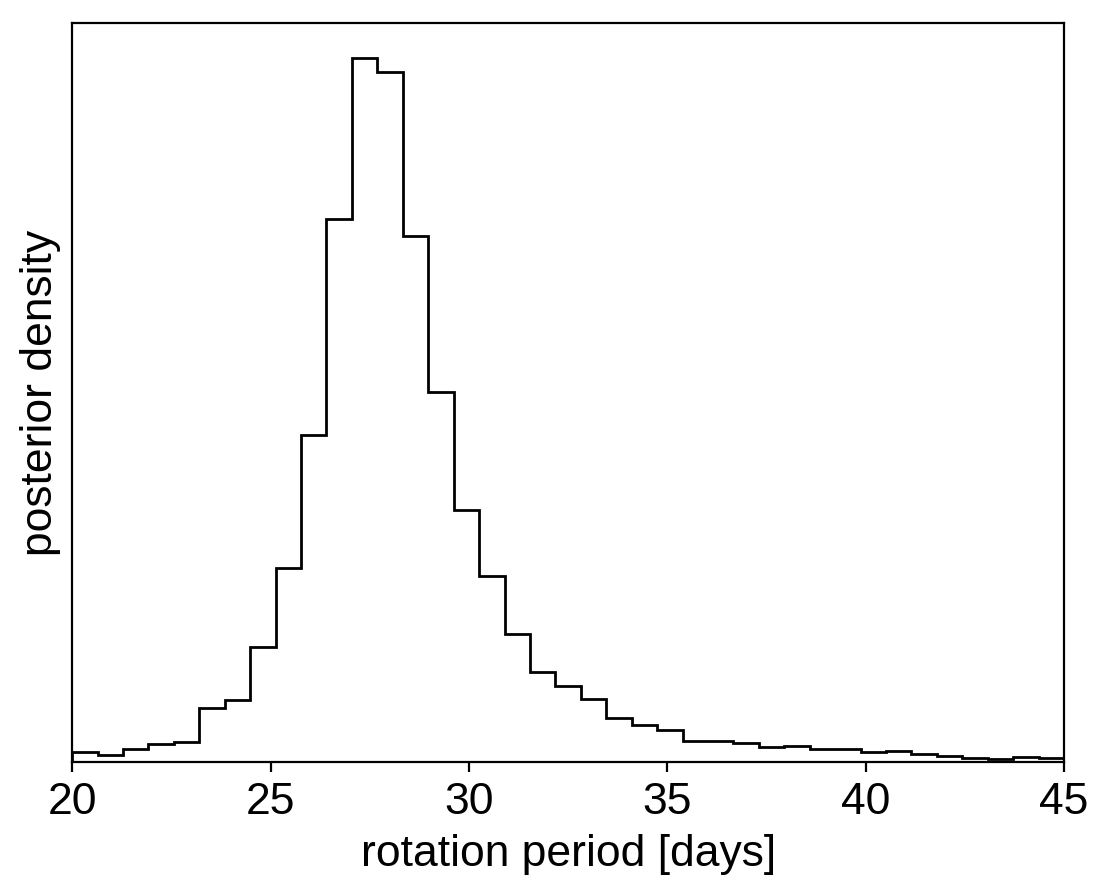

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
